# Glaucoma Segmentation


## Imports

In [1]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import defaultdict
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import wandb

from models import *
from utils import *

## Setup

In [2]:
IMAGE_DIR = '../data/ORIGA/Images_Cropped'
MASK_DIR = '../data/ORIGA/Masks_Cropped'
LOGS_DIR = '../logs'
CHECKPOINT_DIR = '../checkpoints'
IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128
BATCH_SIZE = 4
LEARNING_RATE = 1e-4
EPOCHS = 3
LAYERS = [32, 64, 128, 256, 512]
EARLY_STOPPING_PATIENCE = 10
SAVE_INTERVAL = 10
NUM_WORKERS = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
PIN_MEMORY = True if DEVICE == 'cuda' else False
LOAD_MODEL = ''
USE_WANDB = False

os.makedirs(LOGS_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print(f'PyTorch version: {torch.__version__}')
print(f'Using device: {DEVICE}')

PyTorch version: 2.0.1+cu118
Using device: cuda


## Model

In [7]:
model = UNet(in_channels=3, out_channels=3, features=LAYERS).to(DEVICE)
criterion = IoULoss(num_classes=3, device=DEVICE)

images = torch.randn((BATCH_SIZE, 3, IMAGE_HEIGHT, IMAGE_WIDTH)).to(DEVICE)
# masks = torch.randint(0, 3, (BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH)).to(DEVICE)

# images, masks = next(iter(test_loader))
# images = images.to(DEVICE)
# masks = masks.long().to(DEVICE)

print(f'{images.shape = }')
# print(f'{masks.shape = }')
# print('Unique values in masks:', torch.unique(masks))

outputs = model(images)
print(f'{outputs.shape = }')
print()

masks = torch.argmax(outputs, dim=1).long()
print(f'{masks.shape = }')
print('Unique values in masks:', torch.unique(masks))

loss = criterion(outputs, masks)
print(f'Loss: {loss.item():.4f}')

loss.backward()


images.shape = torch.Size([4, 3, 128, 128])
outputs.shape = torch.Size([4, 3, 128, 128])

masks.shape = torch.Size([4, 128, 128])
Unique values in masks: tensor([0, 1, 2], device='cuda:0')
Loss: 0.6358


In [6]:
# initialize model, loss, optimizer, scheduler, scaler, ...
model = UNet(in_channels=3, out_channels=3, features=LAYERS).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# criterion = nn.CrossEntropyLoss()  # softmax layer is already included inside nn.CrossEntropyLoss()
# criterion = DiceLoss(num_classes=3, device=DEVICE, class_weights=[1.0, 1.0, 1.0])
criterion = IoULoss(num_classes=3)

# scheduler = None
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=True)

scaler = None
# scaler = torch.cuda.amp.GradScaler()

if LOAD_MODEL:
    load_checkpoint(LOAD_MODEL, model, optimizer)

## Weights & Biases

In [7]:
if USE_WANDB:
    wandb.login()

In [8]:
config = {
    'image_size': (IMAGE_HEIGHT, IMAGE_WIDTH),
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'epochs': EPOCHS,
    'dataset': 'ORIGA',
    'layers': LAYERS,
}

# Initialize Weights & Biases
if USE_WANDB:
    wandb.init(project='DP-Glaucoma', config=config)

## Dataset

Image shape: torch.Size([1, 3, 128, 128])
Mask shape: torch.Size([1, 128, 128])
Unique values and their counts in mask: {0: 5922, 1: 5486, 2: 4976}


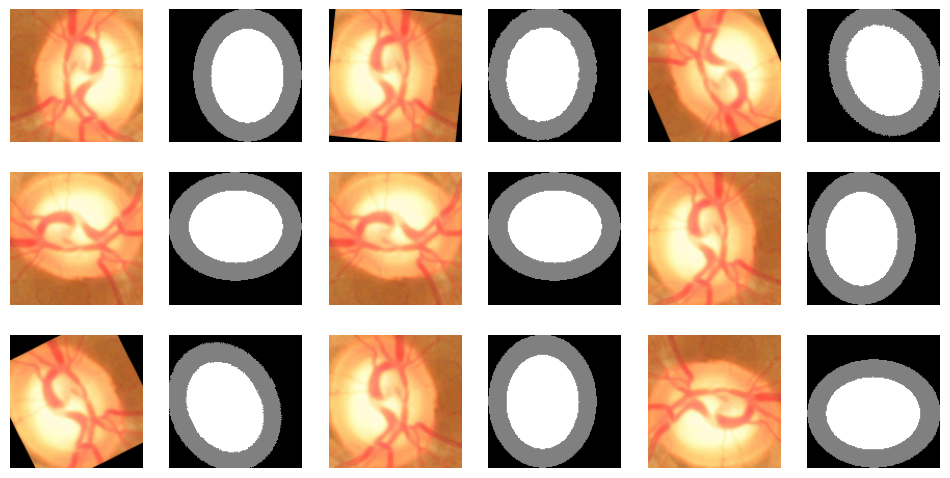

In [9]:
example_ds = OrigaDataset(IMAGE_DIR, MASK_DIR, os.listdir(IMAGE_DIR)[:1], A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=1.0),  # rotate by 0, 90, 180, or 270 degrees
    A.Rotate(limit=30, p=0.33, border_mode=cv.BORDER_CONSTANT),
    A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),
    ToTensorV2(),
]))
example_loader = DataLoader(example_ds, batch_size=1, shuffle=True)

example_image, example_mask = next(iter(example_loader))
print(f'Image shape: {example_image.shape}')
print(f'Mask shape: {example_mask.shape}')

unique, counts = np.unique(example_mask, return_counts=True)
print(f'Unique values and their counts in mask: {dict(zip(unique, counts))}')

# Plot example augmented images and masks
fig, ax = plt.subplots(3, 6, figsize=(12, 6))
ax = ax.ravel()
for i in range(0, 3 * 6, 2):
    batch = next(iter(example_loader))
    images, masks = batch
    image, mask = images[0], masks[0]
    image = image.permute(1, 2, 0).numpy()
    mask = mask.numpy()
    ax[i].imshow(image)
    ax[i].axis('off')
    ax[i + 1].imshow(mask, cmap='gray')
    ax[i + 1].axis('off')
plt.show()

In [10]:
train_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=1.0),
    A.Rotate(limit=30, p=0.25, border_mode=cv.BORDER_CONSTANT),
    A.Normalize(mean=ORIGA_MEANS, std=ORIGA_STDS),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(mean=ORIGA_MEANS, std=ORIGA_STDS),
    ToTensorV2()
])

train_ds, val_ds, test_ds = load_origa(
    IMAGE_DIR, MASK_DIR, train_transform, val_transform, val_transform,
    train_size=0.7, val_size=0.15, test_size=0.15,
    # train_size=0.01, val_size=0.01, test_size=0.98,
)

print(f'Train size: {len(train_ds)}')
print(f'Validation size: {len(val_ds)}')
print(f'Test size: {len(test_ds)}')

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=PIN_MEMORY, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, pin_memory=PIN_MEMORY, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, pin_memory=PIN_MEMORY, num_workers=NUM_WORKERS)

Train size: 454
Validation size: 98
Test size: 98


## Training

In [11]:
hist = train(
    model, criterion, optimizer, EPOCHS, DEVICE, train_loader, val_loader, scheduler, scaler,
    save_interval=SAVE_INTERVAL, early_stopping_patience=EARLY_STOPPING_PATIENCE,
    log_to_wandb=USE_WANDB, log_dir=LOGS_DIR, checkpoint_dir=CHECKPOINT_DIR,
)

Epoch 1:


Training:   1%|          | 1/114 [00:04<08:30,  4.52s/it]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.1975, 0.1751, 0.2058],
        [0.2209, 0.1933, 0.1473],
        [0.2491, 0.1773, 0.1607],
        [0.1948, 0.1755, 0.2020]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.1928, 0.1872, 0.1957, 0.1907], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.1916, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.1778, 0.2404, 0.1209],
        [0.1697, 0.1787, 0.2748],
        [0.2050, 0.2062, 0.1728],
        [0.2694, 0

Training:   3%|▎         | 3/114 [00:04<02:02,  1.11s/it]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.2242, 0.1646, 0.1644],
        [0.1870, 0.1872, 0.1838],
        [0.1880, 0.1952, 0.2048],
        [0.2824, 0.1961, 0.2073]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.1844, 0.1860, 0.1960, 0.2286], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.1987, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.2516, 0.1779, 0.2081],
        [0.2166, 0.1742, 0.1808],
        [0.1779, 0.1996, 0.0575],
        [0.2184, 0

Training:   4%|▍         | 5/114 [00:04<00:54,  2.02it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.2464, 0.1260, 0.2212],
        [0.2103, 0.1334, 0.2832],
        [0.2059, 0.2465, 0.1946],
        [0.1989, 0.1959, 0.0710]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.1979, 0.2090, 0.2157, 0.1553], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.1944, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.2297, 0.1906, 0.1797],
        [0.1565, 0.2076, 0.1856],
        [0.3096, 0.2056, 0.2140],
        [0.2080, 0

Training:   6%|▌         | 7/114 [00:05<00:29,  3.58it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.2418, 0.2432, 0.1887],
        [0.2935, 0.2554, 0.1768],
        [0.3318, 0.1698, 0.3099],
        [0.2814, 0.2255, 0.1411]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.2245, 0.2419, 0.2705, 0.2160], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.2382, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.2327, 0.2217, 0.1804],
        [0.3560, 0.2040, 0.1943],
        [0.1549, 0.2189, 0.1858],
        [0.2791, 0

Training:   8%|▊         | 9/114 [00:05<00:19,  5.40it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.3102, 0.1886, 0.2967],
        [0.2847, 0.1971, 0.2535],
        [0.3576, 0.1736, 0.2620],
        [0.2611, 0.2100, 0.1546]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.2652, 0.2451, 0.2644, 0.2086], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.2458, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.2425, 0.2098, 0.2502],
        [0.3352, 0.2218, 0.2335],
        [0.3480, 0.2512, 0.1812],
        [0.3315, 0

Training:  10%|▉         | 11/114 [00:05<00:15,  6.86it/s]

iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.3255, 0.2691, 0.1355],
        [0.4266, 0.1817, 0.3888],
        [0.2601, 0.1685, 0.3904],
        [0.3115, 0.2617, 0.2183]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.2434, 0.3324, 0.2730, 0.2638], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.2781, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.2746, 0.2165, 0.1616],
        [0.3522, 0.2335, 0.1937],
        [0.3604, 0.2397, 0.3162],
        [0.3695, 0.2333, 0.3936]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.2175, 0.2598, 0.3054, 0.3321], device='cuda:0',
       grad_

Training:  13%|█▎        | 15/114 [00:06<00:11,  8.51it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.3265, 0.2823, 0.2338],
        [0.3947, 0.1586, 0.4348],
        [0.3828, 0.2313, 0.3329],
        [0.3945, 0.2784, 0.1358]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.2809, 0.3294, 0.3157, 0.2695], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.2989, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.4625, 0.2437, 0.1673],
        [0.1993, 0.2422, 0.1368],
        [0.3556, 0.3073, 0.2470],
        [0.4682, 0

Training:  15%|█▍        | 17/114 [00:06<00:10,  8.85it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.4311, 0.1636, 0.3539],
        [0.4308, 0.2405, 0.4059],
        [0.3817, 0.2630, 0.2649],
        [0.3305, 0.1722, 0.3996]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.3162, 0.3591, 0.3032, 0.3008], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.3198, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.4822, 0.2909, 0.3128],
        [0.5455, 0.2242, 0.4691],
        [0.2123, 0.2665, 0.0819],
        [0.4241, 0

Training:  17%|█▋        | 19/114 [00:06<00:10,  9.21it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.3537, 0.2840, 0.2644],
        [0.3529, 0.2713, 0.1447],
        [0.4651, 0.2391, 0.4147],
        [0.3789, 0.2342, 0.2957]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.3007, 0.2563, 0.3730, 0.3029], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.3082, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.4444, 0.2404, 0.2534],
        [0.5875, 0.3163, 0.1848],
        [0.4776, 0.3073, 0.2509],
        [0.4224, 0

Training:  18%|█▊        | 21/114 [00:06<00:09,  9.36it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.5479, 0.2729, 0.1244],
        [0.2185, 0.2194, 0.2408],
        [0.4211, 0.2867, 0.3265],
        [0.4393, 0.3160, 0.2632]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.3150, 0.2262, 0.3448, 0.3395], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.3064, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.5025, 0.2898, 0.3987],
        [0.5352, 0.3470, 0.1566],
        [0.3217, 0.2631, 0.3915],
        [0.3345, 0

Training:  19%|█▉        | 22/114 [00:06<00:09,  9.44it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.4867, 0.2611, 0.3174],
        [0.2768, 0.2164, 0.3281],
        [0.4887, 0.2670, 0.3380],
        [0.6146, 0.2703, 0.4496]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.3551, 0.2738, 0.3646, 0.4448], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.3595, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.5588, 0.2706, 0.4814],
        [0.5209, 0.2714, 0.3623],
        [0.4912, 0.2655, 0.4386],
        [0.5011, 0

Training:  21%|██        | 24/114 [00:06<00:09,  9.71it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.4625, 0.3103, 0.3790],
        [0.6459, 0.2472, 0.2915],
        [0.3108, 0.2653, 0.3145],
        [0.6044, 0.3110, 0.3727]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.3839, 0.3949, 0.2969, 0.4294], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.3763, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.5859, 0.3289, 0.2096],
        [0.5313, 0.2894, 0.3108],
        [0.4557, 0.2977, 0.2944],
        [0.2472, 0

Training:  24%|██▎       | 27/114 [00:07<00:09,  9.64it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.4517, 0.3417, 0.2027],
        [0.4099, 0.3017, 0.1857],
        [0.6198, 0.2819, 0.4636],
        [0.6145, 0.2628, 0.5061]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.3321, 0.2991, 0.4551, 0.4611], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.3868, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.4090, 0.2263, 0.2044],
        [0.5765, 0.3758, 0.2286],
        [0.6318, 0.2747, 0.5330],
        [0.5413, 0

Training:  25%|██▍       | 28/114 [00:07<00:08,  9.60it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.5111, 0.2889, 0.2714],
        [0.4828, 0.1830, 0.4975],
        [0.5228, 0.3807, 0.1950],
        [0.5933, 0.2826, 0.2790]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.3571, 0.3877, 0.3662, 0.3850], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.3740, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.3974, 0.3534, 0.2519],
        [0.5626, 0.2956, 0.3285],
        [0.5321, 0.2829, 0.2621],
        [0.5957, 0

Training:  28%|██▊       | 32/114 [00:07<00:08, 10.18it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.4870, 0.3172, 0.3473],
        [0.6725, 0.3244, 0.2057],
        [0.5070, 0.3240, 0.3385],
        [0.6556, 0.3060, 0.3235]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.3838, 0.4009, 0.3898, 0.4284], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.4007, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.5462, 0.3446, 0.2571],
        [0.5795, 0.3472, 0.2340],
        [0.4851, 0.2708, 0.3361],
        [0.5453, 0

Training:  30%|██▉       | 34/114 [00:07<00:07, 10.14it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.5642, 0.3826, 0.2804],
        [0.5452, 0.2667, 0.4055],
        [0.5350, 0.2655, 0.3684],
        [0.6607, 0.3721, 0.2518]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.4091, 0.4058, 0.3896, 0.4282], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.4082, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6763, 0.3426, 0.4198],
        [0.6447, 0.2853, 0.4329],
        [0.5722, 0.2955, 0.2385],
        [0.5348, 0

Training:  33%|███▎      | 38/114 [00:08<00:07,  9.99it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6986, 0.3261, 0.4096],
        [0.7576, 0.3833, 0.2011],
        [0.2687, 0.2926, 0.3836],
        [0.6009, 0.3704, 0.4389]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.4781, 0.4473, 0.3149, 0.4701], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.4276, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6568, 0.3790, 0.2450],
        [0.5086, 0.1970, 0.2095],
        [0.6616, 0.3568, 0.4072],
        [0.6259, 0

Training:  36%|███▌      | 41/114 [00:08<00:07,  9.87it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.5689, 0.3616, 0.5258],
        [0.6179, 0.2340, 0.3411],
        [0.5401, 0.3411, 0.3556],
        [0.4457, 0.2771, 0.2428]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.4855, 0.3977, 0.4123, 0.3219], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.4043, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6937, 0.2947, 0.4422],
        [0.4685, 0.3004, 0.5039],
        [0.6049, 0.2132, 0.4561],
        [0.6506, 0

Training:  38%|███▊      | 43/114 [00:08<00:07,  9.97it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6406, 0.3558, 0.3251],
        [0.3779, 0.2388, 0.2055],
        [0.6419, 0.3397, 0.6000],
        [0.6405, 0.4074, 0.4071]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.4405, 0.2741, 0.5272, 0.4850], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.4317, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.4037, 0.1104, 0.2353],
        [0.6234, 0.2394, 0.4353],
        [0.5422, 0.2123, 0.3564],
        [0.6367, 0

Training:  40%|████      | 46/114 [00:09<00:06, 10.13it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6731, 0.2070, 0.3566],
        [0.5980, 0.4482, 0.3319],
        [0.6513, 0.4105, 0.4955],
        [0.6283, 0.4006, 0.4294]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.4123, 0.4593, 0.5191, 0.4861], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.4692, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.5414, 0.1904, 0.3408],
        [0.7285, 0.4772, 0.3399],
        [0.5161, 0.2801, 0.3349],
        [0.6622, 0

Training:  42%|████▏     | 48/114 [00:09<00:06, 10.22it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6004, 0.2712, 0.3465],
        [0.7403, 0.3685, 0.4316],
        [0.7580, 0.3777, 0.5458],
        [0.6392, 0.4853, 0.3469]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.4060, 0.5134, 0.5605, 0.4905], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.4926, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6530, 0.3260, 0.5121],
        [0.7520, 0.3553, 0.5869],
        [0.5464, 0.3740, 0.3769],
        [0.6367, 0

Training:  44%|████▍     | 50/114 [00:09<00:06, 10.16it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6611, 0.4345, 0.5190],
        [0.4346, 0.2034, 0.3036],
        [0.6744, 0.3702, 0.4839],
        [0.6234, 0.3976, 0.4614]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.5382, 0.3139, 0.5095, 0.4941], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.4639, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6744, 0.3639, 0.4548],
        [0.6656, 0.3820, 0.5876],
        [0.6042, 0.3815, 0.3851],
        [0.6170, 0

Training:  47%|████▋     | 54/114 [00:09<00:05, 10.22it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6083, 0.3023, 0.5750],
        [0.5644, 0.4419, 0.5627],
        [0.5948, 0.0788, 0.5779],
        [0.5765, 0.4915, 0.4091]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.4952, 0.5230, 0.4172, 0.4923], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.4819, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7536, 0.4810, 0.4841],
        [0.4415, 0.2104, 0.5592],
        [0.7173, 0.5149, 0.4092],
        [0.6524, 0

Training:  49%|████▉     | 56/114 [00:10<00:05, 10.24it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7175, 0.5059, 0.4298],
        [0.6761, 0.3047, 0.3866],
        [0.6720, 0.5156, 0.5635],
        [0.7193, 0.5088, 0.5040]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.5511, 0.4558, 0.5837, 0.5774], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.5420, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.3078, 0.0101, 0.0212],
        [0.6387, 0.5372, 0.5510],
        [0.1816, 0.1676, 0.3388],
        [0.5111, 0

Training:  51%|█████     | 58/114 [00:10<00:05, 10.21it/s]

iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.5912, 0.5141, 0.6000],
        [0.7438, 0.3913, 0.6151],
        [0.6804, 0.4905, 0.5467],
        [0.6752, 0.5605, 0.6025]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.5685, 0.5834, 0.5725, 0.6128], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.5843, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7599, 0.2975, 0.3469],
        [0.6602, 0.4548, 0.6114],
        [0.6696, 0.5253, 0.4311],
        [0.6846, 0.2507, 0.5041]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.4681, 0.5755, 0.5420, 0.4798], device='cuda:0',
       grad_

Training:  53%|█████▎    | 60/114 [00:10<00:05, 10.06it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.5370, 0.3513, 0.4724],
        [0.7361, 0.5834, 0.4053],
        [0.7125, 0.4958, 0.4609],
        [0.7131, 0.4325, 0.4632]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.4536, 0.5749, 0.5564, 0.5363], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.5303, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6870, 0.4325, 0.4587],
        [0.6338, 0.5579, 0.5211],
        [0.7602, 0.5088, 0.5360],
        [0.7289, 0

Training:  56%|█████▌    | 64/114 [00:10<00:04, 10.24it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.5161, 0.4292, 0.5627],
        [0.6222, 0.4682, 0.4590],
        [0.5809, 0.2864, 0.4851],
        [0.6688, 0.3510, 0.5480]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.5027, 0.5165, 0.4508, 0.5226], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.4981, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7478, 0.5998, 0.6068],
        [0.7380, 0.5603, 0.6023],
        [0.6127, 0.4036, 0.4553],
        [0.6671, 0

Training:  58%|█████▊    | 66/114 [00:11<00:04, 10.37it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7743, 0.5930, 0.5502],
        [0.4578, 0.2097, 0.4806],
        [0.6757, 0.3518, 0.4052],
        [0.7311, 0.4765, 0.4702]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6392, 0.3827, 0.4776, 0.5593], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.5147, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6642, 0.4932, 0.5005],
        [0.6612, 0.5426, 0.4098],
        [0.6526, 0.4336, 0.4016],
        [0.7300, 0

Training:  60%|█████▉    | 68/114 [00:11<00:04, 10.53it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7547, 0.5433, 0.4850],
        [0.7069, 0.5619, 0.6572],
        [0.7115, 0.5588, 0.6443],
        [0.6565, 0.4881, 0.4629]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.5943, 0.6420, 0.6382, 0.5358], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6026, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7705, 0.5827, 0.6625],
        [0.7851, 0.5829, 0.5433],
        [0.6798, 0.5325, 0.5056],
        [0.6608, 0

Training:  61%|██████▏   | 70/114 [00:11<00:04, 10.50it/s]

iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6402, 0.3461, 0.5216],
        [0.7070, 0.5377, 0.5221],
        [0.6918, 0.6148, 0.6378],
        [0.6841, 0.5167, 0.6370]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.5026, 0.5889, 0.6481, 0.6126], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.5881, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6188, 0.4653, 0.6204],
        [0.6756, 0.4910, 0.5999],
        [0.6432, 0.5407, 0.6065],
        [0.7308, 0.5870, 0.6932]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.5681, 0.5888, 0.5968, 0.6703], device='cuda:0',
       grad_

Training:  63%|██████▎   | 72/114 [00:11<00:04, 10.49it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.5621, 0.3695, 0.3522],
        [0.4287, 0.0433, 0.3214],
        [0.5693, 0.4747, 0.3999],
        [0.6409, 0.5957, 0.6671]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.4279, 0.2645, 0.4813, 0.6346], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.4521, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7734, 0.5561, 0.6498],
        [0.7694, 0.6208, 0.6190],
        [0.5200, 0.3403, 0.4929],
        [0.5527, 0

Training:  67%|██████▋   | 76/114 [00:12<00:03, 10.27it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7234, 0.5325, 0.2853],
        [0.6723, 0.4160, 0.5693],
        [0.7696, 0.5468, 0.4780],
        [0.6231, 0.4116, 0.4536]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.5137, 0.5526, 0.5981, 0.4961], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.5401, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7706, 0.4694, 0.6532],
        [0.7121, 0.5898, 0.6488],
        [0.7290, 0.4801, 0.2604],
        [0.7460, 0

Training:  68%|██████▊   | 78/114 [00:12<00:03, 10.13it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6706, 0.2641, 0.6517],
        [0.7440, 0.5435, 0.5392],
        [0.7069, 0.6643, 0.6184],
        [0.6316, 0.4534, 0.5497]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.5288, 0.6089, 0.6632, 0.5449], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.5864, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6764, 0.6004, 0.6327],
        [0.7779, 0.6855, 0.7024],
        [0.7452, 0.3781, 0.6711],
        [0.5692, 0

Training:  70%|███████   | 80/114 [00:12<00:03, 10.13it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7873, 0.6217, 0.5327],
        [0.7212, 0.6672, 0.7001],
        [0.6951, 0.4732, 0.3504],
        [0.6918, 0.4518, 0.6292]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6472, 0.6962, 0.5062, 0.5909], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6101, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6479, 0.3848, 0.4974],
        [0.7650, 0.4378, 0.4555],
        [0.7004, 0.6483, 0.7093],
        [0.7857, 0

Training:  72%|███████▏  | 82/114 [00:12<00:03, 10.12it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.5190, 0.3957, 0.4862],
        [0.6689, 0.6169, 0.7188],
        [0.6692, 0.5584, 0.4832],
        [0.4885, 0.2550, 0.3689]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.4669, 0.6682, 0.5703, 0.3708], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.5191, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6810, 0.5223, 0.6655],
        [0.6841, 0.5714, 0.6185],
        [0.7275, 0.6006, 0.5241],
        [0.7134, 0

Training:  74%|███████▎  | 84/114 [00:12<00:02, 10.11it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7870, 0.5174, 0.6122],
        [0.7381, 0.6896, 0.7214],
        [0.6953, 0.5882, 0.6400],
        [0.7024, 0.6306, 0.6453]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6389, 0.7164, 0.6412, 0.6594], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6640, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8115, 0.6116, 0.6371],
        [0.7440, 0.6057, 0.6598],
        [0.6186, 0.3703, 0.6756],
        [0.7870, 0

Training:  75%|███████▌  | 86/114 [00:13<00:02, 10.19it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7244, 0.5705, 0.6058],
        [0.7010, 0.4421, 0.3332],
        [0.7298, 0.6284, 0.7214],
        [0.7106, 0.5741, 0.3750]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6335, 0.4921, 0.6932, 0.5532], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.5930, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7928, 0.7000, 0.6982],
        [0.7651, 0.5426, 0.6899],
        [0.7478, 0.5352, 0.5884],
        [0.7124, 0

Training:  77%|███████▋  | 88/114 [00:13<00:02, 10.32it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7069, 0.6510, 0.6222],
        [0.7783, 0.6315, 0.5449],
        [0.6638, 0.4649, 0.3393],
        [0.7405, 0.2712, 0.0647]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6601, 0.6516, 0.4893, 0.3588], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.5399, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7694, 0.6280, 0.5599],
        [0.7213, 0.6117, 0.5294],
        [0.6769, 0.6279, 0.6400],
        [0.7610, 0

Training:  79%|███████▉  | 90/114 [00:13<00:02, 10.38it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6823, 0.5163, 0.6204],
        [0.7229, 0.6059, 0.6235],
        [0.7172, 0.5939, 0.7084],
        [0.6687, 0.4639, 0.5543]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6063, 0.6508, 0.6732, 0.5623], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6232, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7521, 0.6399, 0.6524],
        [0.7457, 0.6153, 0.6002],
        [0.7741, 0.6055, 0.4040],
        [0.7123, 0

Training:  82%|████████▏ | 94/114 [00:13<00:01, 10.53it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7104, 0.5958, 0.7302],
        [0.7086, 0.4624, 0.5156],
        [0.7687, 0.6142, 0.6550],
        [0.7246, 0.6499, 0.7481]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6788, 0.5622, 0.6793, 0.7075], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6570, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7720, 0.6622, 0.6348],
        [0.7492, 0.5145, 0.4314],
        [0.7260, 0.4919, 0.6451],
        [0.7116, 0

Training:  84%|████████▍ | 96/114 [00:13<00:01, 10.46it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6570, 0.5626, 0.6111],
        [0.7622, 0.6247, 0.5199],
        [0.6961, 0.5533, 0.5212],
        [0.7007, 0.5659, 0.5168]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6102, 0.6356, 0.5902, 0.5944], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6076, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8219, 0.6737, 0.6261],
        [0.6626, 0.6303, 0.7195],
        [0.7314, 0.5586, 0.6481],
        [0.6459, 0

Training:  88%|████████▊ | 100/114 [00:14<00:01, 10.46it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6977, 0.6529, 0.7049],
        [0.7875, 0.2690, 0.1426],
        [0.8027, 0.6854, 0.5860],
        [0.7026, 0.4102, 0.5325]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6852, 0.3997, 0.6914, 0.5484], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.5812, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.5819, 0.4010, 0.4675],
        [0.6141, 0.4263, 0.5999],
        [0.7506, 0.6454, 0.6385],
        [0.7501, 0

Training:  89%|████████▉ | 102/114 [00:14<00:01, 10.49it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6636, 0.4666, 0.6195],
        [0.6492, 0.4830, 0.6379],
        [0.6996, 0.5839, 0.6339],
        [0.7325, 0.6373, 0.6758]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.5833, 0.5900, 0.6391, 0.6819], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6236, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8511, 0.6270, 0.4476],
        [0.7079, 0.6498, 0.5572],
        [0.3678, 0.0545, 0.3391],
        [0.7914, 0

Training:  91%|█████████ | 104/114 [00:14<00:00, 10.41it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6766, 0.5766, 0.4814],
        [0.7796, 0.6019, 0.4544],
        [0.7650, 0.6978, 0.7251],
        [0.7155, 0.6279, 0.6906]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.5782, 0.6120, 0.7293, 0.6780], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6494, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.4389, 0.2979, 0.5105],
        [0.7529, 0.6397, 0.7258],
        [0.6303, 0.5912, 0.5959],
        [0.8047, 0

Training:  93%|█████████▎| 106/114 [00:14<00:00, 10.49it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7214, 0.5285, 0.6763],
        [0.8249, 0.7344, 0.7679],
        [0.7685, 0.6021, 0.5073],
        [0.7445, 0.6661, 0.7055]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6421, 0.7757, 0.6260, 0.7054], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6873, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6925, 0.6423, 0.6957],
        [0.7207, 0.6245, 0.5935],
        [0.8354, 0.7107, 0.7408],
        [0.7170, 0

Training:  95%|█████████▍| 108/114 [00:15<00:00, 10.63it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7695, 0.6977, 0.7036],
        [0.7344, 0.3814, 0.6556],
        [0.8183, 0.6961, 0.6248],
        [0.7717, 0.7561, 0.7806]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7236, 0.5905, 0.7131, 0.7694], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6991, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6881, 0.6531, 0.7514],
        [0.7525, 0.6418, 0.6071],
        [0.7579, 0.7067, 0.7189],
        [0.7065, 0

Training:  96%|█████████▋| 110/114 [00:15<00:00, 10.64it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7334, 0.4633, 0.5697],
        [0.7539, 0.7224, 0.7527],
        [0.7826, 0.6762, 0.5608],
        [0.7769, 0.6753, 0.6204]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.5888, 0.7430, 0.6732, 0.6909], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6740, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6813, 0.6855, 0.7407],
        [0.7732, 0.7439, 0.7357],
        [0.7407, 0.5449, 0.5010],
        [0.8026, 0

Training:  98%|█████████▊| 112/114 [00:15<00:00, 10.53it/s]

iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7852, 0.5984, 0.6224],
        [0.8434, 0.7460, 0.7282],
        [0.6377, 0.5725, 0.6763],
        [0.8179, 0.6757, 0.4565]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6687, 0.7725, 0.6288, 0.6500], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6800, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8028, 0.6083, 0.6612],
        [0.7582, 0.6579, 0.6793],
        [0.8338, 0.7373, 0.7370],
        [0.7728, 0.5966, 0.6663]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6907, 0.6985, 0.7694, 0.6786], device='cuda:0',
       grad_

Validation:   8%|▊         | 2/25 [00:04<00:41,  1.81s/it]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7417, 0.5299, 0.6426],
        [0.7733, 0.5321, 0.7251],
        [0.2889, 0.0073, 0.2988],
        [0.7310, 0.6401, 0.7108]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6381, 0.6768, 0.1983, 0.6940], device='cuda:0')
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.5518, device='cuda:0')
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8021, 0.4414, 0.6577],
        [0.7526, 0.7003, 0.7214],
        [0.5463, 0.2762, 0.3420],
        [0.8170, 0.4442, 0.4474]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores 

Validation:  20%|██        | 5/25 [00:04<00:09,  2.04it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7976, 0.6939, 0.7635],
        [0.7794, 0.6652, 0.7253],
        [0.7800, 0.6775, 0.5947],
        [0.6703, 0.4948, 0.6893]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7517, 0.7233, 0.6841, 0.6181], device='cuda:0')
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6943, device='cuda:0')
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8368, 0.6443, 0.5857],
        [0.8127, 0.6838, 0.4971],
        [0.7674, 0.5230, 0.6600],
        [0.8011, 0.6805, 0.7514]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores 

Validation:  28%|██▊       | 7/25 [00:04<00:05,  3.32it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7868, 0.7099, 0.6170],
        [0.8315, 0.6948, 0.6595],
        [0.7926, 0.6258, 0.4487],
        [0.8448, 0.6412, 0.6020]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7046, 0.7286, 0.6224, 0.6960], device='cuda:0')
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6879, device='cuda:0')
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8440, 0.7236, 0.7273],
        [0.7040, 0.5963, 0.6893],
        [0.7630, 0.6967, 0.6033],
        [0.7991, 0.6722, 0.7239]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores 

Validation:  44%|████▍     | 11/25 [00:05<00:02,  6.31it/s]

iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7290, 0.6283, 0.6166],
        [0.7940, 0.6820, 0.7373],
        [0.7758, 0.6541, 0.6575],
        [0.7703, 0.7083, 0.6571]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6579, 0.7378, 0.6958, 0.7119], device='cuda:0')
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7009, device='cuda:0')
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8012, 0.7728, 0.7872],
        [0.8010, 0.5387, 0.6692],
        [0.8002, 0.4073, 0.5896],
        [0.7862, 0.6579, 0.6277]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7871, 0.6696, 0.5990, 0.6906], device='cuda:0')
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6866, device='cuda:0')
targets_one_hot.shape = torch.Size([4

Validation:  52%|█████▏    | 13/25 [00:05<00:01,  7.82it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6498, 0.5891, 0.6446],
        [0.8107, 0.7104, 0.7651],
        [0.4657, 0.3555, 0.7122],
        [0.6261, 0.1405, 0.5638]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6279, 0.7621, 0.5111, 0.4435], device='cuda:0')
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.5861, device='cuda:0')
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6369, 0.5707, 0.6565],
        [0.7060, 0.6520, 0.5729],
        [0.7193, 0.6745, 0.5437],
        [0.6921, 0.6030, 0.6962]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores 

Validation:  68%|██████▊   | 17/25 [00:05<00:00, 10.60it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8229, 0.5096, 0.6952],
        [0.7977, 0.6757, 0.7121],
        [0.8178, 0.6682, 0.6747],
        [0.7662, 0.7323, 0.7753]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6759, 0.7285, 0.7202, 0.7579], device='cuda:0')
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7206, device='cuda:0')
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.5899, 0.3857, 0.6632],
        [0.7366, 0.6577, 0.6965],
        [0.7436, 0.3433, 0.5648],
        [0.6283, 0.5651, 0.6993]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores 

Validation:  76%|███████▌  | 19/25 [00:05<00:00, 11.71it/s]

iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7430, 0.5776, 0.3912],
        [0.7849, 0.6557, 0.5495],
        [0.6743, 0.5922, 0.5486],
        [0.6494, 0.4728, 0.6747]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.5706, 0.6634, 0.6051, 0.5990], device='cuda:0')
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6095, device='cuda:0')
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6604, 0.5055, 0.3344],
        [0.7062, 0.5939, 0.5967],
        [0.7784, 0.6505, 0.5392],
        [0.5268, 0.1855, 0.6487]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.5001, 0.6323, 0.6561, 0.4537], device='cuda:0')
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.5605, device='cuda:0')
targets_one_hot.shape = torch.Size([4

Validation:  92%|█████████▏| 23/25 [00:05<00:00, 13.18it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7659, 0.6761, 0.7467],
        [0.7994, 0.7051, 0.6304],
        [0.7848, 0.6521, 0.7313],
        [0.7904, 0.5621, 0.5773]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7296, 0.7116, 0.7228, 0.6433], device='cuda:0')
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7018, device='cuda:0')
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7618, 0.6978, 0.6868],
        [0.7465, 0.6076, 0.5318],
        [0.8218, 0.6157, 0.7443],
        [0.7904, 0.6353, 0.5547]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores 

Validation: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s, accuracy=0.836, dice=0.839, iou=0.728, loss=0.342, precision=0.835, sensitivity=0.858, specificity=0.915]


=> Saving checkpoint: ../checkpoints\best-model.pth
Epoch 2:


Training:   1%|          | 1/114 [00:04<08:13,  4.37s/it]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.5812, 0.6123, 0.6345],
        [0.6182, 0.6382, 0.7256],
        [0.5155, 0.6370, 0.7250],
        [0.3660, 0.0156, 0.4509]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6093, 0.6607, 0.6258, 0.2775], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.5433, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8044, 0.6610, 0.5282],
        [0.7973, 0.5706, 0.6235],
        [0.6847, 0.5420, 0.4864],
        [0.7079, 0

Training:   3%|▎         | 3/114 [00:04<01:57,  1.06s/it]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8319, 0.7279, 0.7449],
        [0.7884, 0.6491, 0.3540],
        [0.8089, 0.6787, 0.5900],
        [0.7963, 0.6270, 0.6552]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7682, 0.5971, 0.6925, 0.6928], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6877, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7217, 0.7141, 0.6911],
        [0.8219, 0.6161, 0.6543],
        [0.7159, 0.6934, 0.6971],
        [0.8302, 0

Training:   4%|▍         | 5/114 [00:04<00:56,  1.94it/s]

iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7572, 0.6701, 0.6580],
        [0.8197, 0.7199, 0.6768],
        [0.6419, 0.4122, 0.5404],
        [0.7442, 0.6214, 0.6722]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6951, 0.7388, 0.5315, 0.6793], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6612, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7029, 0.6284, 0.4769],
        [0.7544, 0.6702, 0.6640],
        [0.8080, 0.6716, 0.6532],
        [0.4120, 0.1620, 0.5581]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6027, 0.6962, 0.7110, 0.3774], device='cuda:0',
       grad_

Training:   8%|▊         | 9/114 [00:05<00:24,  4.22it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7452, 0.6188, 0.4711],
        [0.7688, 0.6602, 0.7128],
        [0.8100, 0.6981, 0.6505],
        [0.7951, 0.7406, 0.6727]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6117, 0.7139, 0.7195, 0.7361], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6953, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7882, 0.5160, 0.6717],
        [0.7379, 0.6737, 0.7093],
        [0.7476, 0.6512, 0.6910],
        [0.6645, 0

Training:  10%|▉         | 11/114 [00:05<00:19,  5.36it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.5819, 0.5247, 0.5182],
        [0.7226, 0.6284, 0.7254],
        [0.7517, 0.6445, 0.6202],
        [0.7784, 0.7105, 0.6422]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.5416, 0.6922, 0.6721, 0.7103], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6541, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8143, 0.7230, 0.6263],
        [0.8222, 0.7507, 0.7305],
        [0.7852, 0.7218, 0.7813],
        [0.8385, 0

Training:  11%|█▏        | 13/114 [00:05<00:15,  6.45it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8244, 0.6826, 0.7330],
        [0.8057, 0.6797, 0.7448],
        [0.8222, 0.7051, 0.5924],
        [0.7545, 0.5675, 0.5915]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7466, 0.7434, 0.7066, 0.6378], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7086, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7794, 0.7457, 0.7261],
        [0.7452, 0.7028, 0.7636],
        [0.7722, 0.6669, 0.6780],
        [0.7985, 0

Training:  13%|█▎        | 15/114 [00:05<00:13,  7.43it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8657, 0.6805, 0.4739],
        [0.7816, 0.6914, 0.6032],
        [0.5761, 0.4210, 0.4904],
        [0.8232, 0.7240, 0.6977]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6734, 0.6921, 0.4958, 0.7483], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6524, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6289, 0.5829, 0.6309],
        [0.7874, 0.7212, 0.7401],
        [0.8471, 0.6814, 0.6672],
        [0.8533, 0

Training:  15%|█▍        | 17/114 [00:05<00:11,  8.24it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.4661, 0.0123, 0.5879],
        [0.7575, 0.7615, 0.6942],
        [0.6824, 0.7381, 0.7135],
        [0.7108, 0.6835, 0.7241]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.3554, 0.7377, 0.7113, 0.7062], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6277, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7308, 0.6955, 0.7114],
        [0.7951, 0.7574, 0.7349],
        [0.8535, 0.6868, 0.6342],
        [0.8130, 0

Training:  17%|█▋        | 19/114 [00:06<00:10,  8.87it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8674, 0.6880, 0.7031],
        [0.7512, 0.7121, 0.7684],
        [0.7781, 0.6970, 0.7904],
        [0.6390, 0.6791, 0.7233]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7528, 0.7439, 0.7552, 0.6805], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7331, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6278, 0.6476, 0.7004],
        [0.6738, 0.6916, 0.7098],
        [0.4450, 0.0121, 0.5586],
        [0.5310, 0

Training:  18%|█▊        | 21/114 [00:06<00:09,  9.41it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6905, 0.6171, 0.7533],
        [0.6998, 0.6427, 0.6994],
        [0.7696, 0.6654, 0.5567],
        [0.7520, 0.6280, 0.7437]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6870, 0.6806, 0.6639, 0.7079], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6849, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8323, 0.6856, 0.6520],
        [0.7515, 0.5566, 0.4952],
        [0.8162, 0.7261, 0.6606],
        [0.8273, 0

Training:  20%|██        | 23/114 [00:06<00:09,  9.71it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7779, 0.6377, 0.5568],
        [0.8419, 0.7218, 0.6830],
        [0.7598, 0.5791, 0.6148],
        [0.5057, 0.1301, 0.6197]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6575, 0.7489, 0.6512, 0.4185], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6190, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7997, 0.5389, 0.3543],
        [0.7655, 0.6992, 0.6000],
        [0.8248, 0.6730, 0.6118],
        [0.8317, 0

Training:  24%|██▎       | 27/114 [00:06<00:08, 10.19it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8015, 0.6019, 0.5428],
        [0.7592, 0.7381, 0.7612],
        [0.7917, 0.6132, 0.4371],
        [0.7632, 0.5596, 0.6483]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6487, 0.7528, 0.6140, 0.6571], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6682, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7648, 0.6678, 0.5423],
        [0.7928, 0.6902, 0.6237],
        [0.7720, 0.6590, 0.7082],
        [0.7635, 0

Training:  25%|██▌       | 29/114 [00:07<00:08, 10.33it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7563, 0.6822, 0.7097],
        [0.8168, 0.6893, 0.6653],
        [0.7220, 0.6124, 0.5986],
        [0.7877, 0.4762, 0.6204]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7161, 0.7238, 0.6443, 0.6281], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6781, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6861, 0.6490, 0.7097],
        [0.8130, 0.7230, 0.7105],
        [0.7211, 0.5465, 0.4259],
        [0.7447, 0

Training:  27%|██▋       | 31/114 [00:07<00:08, 10.34it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8297, 0.6831, 0.6204],
        [0.7949, 0.6474, 0.5627],
        [0.7369, 0.6994, 0.7363],
        [0.7778, 0.7600, 0.8198]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7111, 0.6684, 0.7242, 0.7859], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7224, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7810, 0.6015, 0.6725],
        [0.6356, 0.5501, 0.5760],
        [0.7481, 0.7063, 0.7374],
        [0.7877, 0

Training:  29%|██▉       | 33/114 [00:07<00:07, 10.44it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8555, 0.7011, 0.7501],
        [0.7439, 0.6108, 0.4208],
        [0.8728, 0.7081, 0.7560],
        [0.8108, 0.7877, 0.8145]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7689, 0.5919, 0.7789, 0.8044], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7360, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7436, 0.6505, 0.6191],
        [0.8273, 0.5916, 0.5330],
        [0.8087, 0.7418, 0.7592],
        [0.6920, 0

Training:  31%|███       | 35/114 [00:07<00:07, 10.47it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6276, 0.5285, 0.5456],
        [0.7286, 0.4514, 0.5664],
        [0.7682, 0.6449, 0.6147],
        [0.8427, 0.6809, 0.5830]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.5672, 0.5821, 0.6759, 0.7022], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6319, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.5208, 0.4942, 0.5037],
        [0.8654, 0.7055, 0.6793],
        [0.7980, 0.7803, 0.8111],
        [0.8223, 0

Training:  32%|███▏      | 37/114 [00:07<00:07, 10.35it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7871, 0.7366, 0.7488],
        [0.7754, 0.6675, 0.6652],
        [0.8255, 0.6897, 0.6090],
        [0.6965, 0.6098, 0.6013]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7575, 0.7027, 0.7081, 0.6359], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7010, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7662, 0.6293, 0.5631],
        [0.7094, 0.6863, 0.7083],
        [0.7833, 0.7009, 0.7021],
        [0.7784, 0

Training:  34%|███▍      | 39/114 [00:07<00:07, 10.52it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7659, 0.7263, 0.7519],
        [0.7656, 0.6209, 0.5950],
        [0.4257, 0.4181, 0.4509],
        [0.8371, 0.6454, 0.7145]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7480, 0.6605, 0.4315, 0.7323], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6431, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7975, 0.7512, 0.7847],
        [0.8192, 0.7396, 0.6985],
        [0.6882, 0.5657, 0.6347],
        [0.7913, 0

Training:  36%|███▌      | 41/114 [00:08<00:07, 10.38it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8425, 0.7215, 0.5476],
        [0.7517, 0.6764, 0.6851],
        [0.7746, 0.5344, 0.5441],
        [0.8390, 0.7096, 0.6904]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7039, 0.7044, 0.6177, 0.7463], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6931, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7278, 0.5511, 0.5806],
        [0.7920, 0.6812, 0.5734],
        [0.8814, 0.5693, 0.1814],
        [0.8532, 0

Training:  38%|███▊      | 43/114 [00:08<00:06, 10.43it/s]

iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7526, 0.7241, 0.7004],
        [0.8462, 0.7015, 0.6202],
        [0.7116, 0.6812, 0.7382],
        [0.8332, 0.7187, 0.7141]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7257, 0.7226, 0.7103, 0.7553], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7285, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8524, 0.7162, 0.7225],
        [0.7826, 0.6785, 0.5691],
        [0.8266, 0.7368, 0.6429],
        [0.8616, 0.7522, 0.6334]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7637, 0.6767, 0.7354, 0.7491], device='cuda:0',
       grad_

Training:  41%|████      | 47/114 [00:08<00:06, 10.52it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8566, 0.7786, 0.7301],
        [0.8333, 0.6935, 0.5780],
        [0.8214, 0.7178, 0.5905],
        [0.7817, 0.6449, 0.5997]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7884, 0.7016, 0.7099, 0.6754], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7188, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.5617, 0.4438, 0.4478],
        [0.8239, 0.7019, 0.5978],
        [0.8427, 0.6915, 0.6961],
        [0.8846, 0

Training:  43%|████▎     | 49/114 [00:08<00:06, 10.47it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7511, 0.6549, 0.7087],
        [0.8177, 0.7678, 0.7584],
        [0.8153, 0.7281, 0.6335],
        [0.7649, 0.6370, 0.6864]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7049, 0.7813, 0.7256, 0.6961], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7270, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7658, 0.5337, 0.5987],
        [0.7202, 0.1924, 0.4200],
        [0.8135, 0.7568, 0.7467],
        [0.8347, 0

Training:  45%|████▍     | 51/114 [00:09<00:05, 10.55it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8406, 0.7214, 0.7058],
        [0.7895, 0.6929, 0.5763],
        [0.8752, 0.6869, 0.7118],
        [0.6254, 0.4896, 0.6148]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7560, 0.6863, 0.7580, 0.5766], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6942, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7548, 0.7270, 0.7445],
        [0.8289, 0.7088, 0.5121],
        [0.8194, 0.7014, 0.7160],
        [0.8067, 0

Training:  46%|████▋     | 53/114 [00:09<00:05, 10.64it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7381, 0.7070, 0.7109],
        [0.7363, 0.6834, 0.7234],
        [0.8039, 0.5823, 0.5276],
        [0.8211, 0.5567, 0.5848]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7187, 0.7144, 0.6379, 0.6542], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6813, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8032, 0.7686, 0.7837],
        [0.6096, 0.5256, 0.6539],
        [0.6474, 0.6604, 0.7197],
        [0.8127, 0

Training:  48%|████▊     | 55/114 [00:09<00:05, 10.67it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8786, 0.6990, 0.5606],
        [0.7217, 0.5310, 0.2437],
        [0.8443, 0.7912, 0.7408],
        [0.8237, 0.7653, 0.7596]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7127, 0.4988, 0.7921, 0.7829], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6966, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7885, 0.3762, 0.4878],
        [0.8390, 0.7849, 0.8170],
        [0.7842, 0.7697, 0.8095],
        [0.8104, 0

Training:  50%|█████     | 57/114 [00:09<00:05, 10.67it/s]

iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8499, 0.6985, 0.5924],
        [0.8330, 0.7624, 0.6489],
        [0.8223, 0.7579, 0.7374],
        [0.7939, 0.7392, 0.7996]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7136, 0.7481, 0.7725, 0.7776], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7530, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8400, 0.5881, 0.6749],
        [0.7746, 0.7216, 0.7291],
        [0.8143, 0.7116, 0.5951],
        [0.8114, 0.6702, 0.4949]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7010, 0.7418, 0.7070, 0.6588], device='cuda:0',
       grad_

Training:  54%|█████▎    | 61/114 [00:10<00:04, 10.78it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8449, 0.7654, 0.7384],
        [0.8002, 0.7632, 0.7442],
        [0.6210, 0.4412, 0.6264],
        [0.6767, 0.6942, 0.7760]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7829, 0.7692, 0.5629, 0.7157], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7077, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8121, 0.6911, 0.5741],
        [0.6246, 0.5570, 0.6512],
        [0.7620, 0.6515, 0.7676],
        [0.7783, 0

Training:  55%|█████▌    | 63/114 [00:10<00:04, 10.71it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8184, 0.7794, 0.7715],
        [0.4488, 0.2571, 0.7366],
        [0.8502, 0.8162, 0.8084],
        [0.8397, 0.7928, 0.7857]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7898, 0.4808, 0.8249, 0.8061], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7254, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8797, 0.7636, 0.7116],
        [0.7775, 0.7430, 0.7021],
        [0.8331, 0.6069, 0.7054],
        [0.7664, 0

Training:  59%|█████▉    | 67/114 [00:10<00:04, 10.58it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7886, 0.7605, 0.7498],
        [0.7414, 0.6494, 0.7177],
        [0.8368, 0.7752, 0.7905],
        [0.7444, 0.5493, 0.5904]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7663, 0.7028, 0.8008, 0.6280], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7245, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7648, 0.6785, 0.6449],
        [0.8289, 0.3555, 0.5628],
        [0.7344, 0.5966, 0.7104],
        [0.8744, 0

Training:  61%|██████    | 69/114 [00:10<00:04, 10.51it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8492, 0.7801, 0.7865],
        [0.7732, 0.7077, 0.7444],
        [0.8088, 0.7762, 0.7773],
        [0.7597, 0.7280, 0.7287]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.8053, 0.7418, 0.7874, 0.7388], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7683, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7238, 0.6949, 0.7527],
        [0.8541, 0.7596, 0.6789],
        [0.7972, 0.5615, 0.6529],
        [0.7670, 0

Training:  62%|██████▏   | 71/114 [00:11<00:04, 10.52it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.5828, 0.4764, 0.5429],
        [0.7918, 0.7060, 0.7185],
        [0.5449, 0.2136, 0.6524],
        [0.8599, 0.8313, 0.8004]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.5340, 0.7388, 0.4703, 0.8305], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6434, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8523, 0.6569, 0.5439],
        [0.8082, 0.7342, 0.7324],
        [0.7916, 0.5936, 0.6413],
        [0.7971, 0

Training:  64%|██████▍   | 73/114 [00:11<00:03, 10.67it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8100, 0.7833, 0.7895],
        [0.5622, 0.3758, 0.6290],
        [0.7483, 0.6173, 0.5263],
        [0.8495, 0.8156, 0.8264]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7943, 0.5223, 0.6306, 0.8305], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6944, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8123, 0.6864, 0.5783],
        [0.7778, 0.7043, 0.7668],
        [0.8389, 0.6758, 0.7113],
        [0.8368, 0

Training:  66%|██████▌   | 75/114 [00:11<00:03, 10.68it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7887, 0.7594, 0.8030],
        [0.7983, 0.7723, 0.7806],
        [0.8834, 0.8224, 0.7831],
        [0.6694, 0.5751, 0.7432]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7837, 0.7837, 0.8296, 0.6626], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7649, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8351, 0.7543, 0.6017],
        [0.8485, 0.4499, 0.1992],
        [0.8286, 0.7247, 0.7021],
        [0.7597, 0

Training:  68%|██████▊   | 77/114 [00:11<00:03, 10.64it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7468, 0.5718, 0.4452],
        [0.7909, 0.3862, 0.5250],
        [0.8365, 0.7447, 0.6522],
        [0.8176, 0.6318, 0.4508]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.5879, 0.5674, 0.7445, 0.6334], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6333, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.5753, 0.4411, 0.6573],
        [0.8024, 0.6348, 0.4480],
        [0.7779, 0.7289, 0.6117],
        [0.8820, 0

Training:  69%|██████▉   | 79/114 [00:11<00:03, 10.67it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8157, 0.5849, 0.6372],
        [0.8232, 0.6606, 0.7010],
        [0.7977, 0.7270, 0.8249],
        [0.7587, 0.7423, 0.7076]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6793, 0.7283, 0.7832, 0.7362], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7317, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8303, 0.7709, 0.7968],
        [0.8355, 0.6531, 0.3513],
        [0.7913, 0.6388, 0.7237],
        [0.7714, 0

Training:  71%|███████   | 81/114 [00:11<00:03, 10.57it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8429, 0.6620, 0.7158],
        [0.8409, 0.7633, 0.7587],
        [0.8162, 0.7784, 0.7744],
        [0.8401, 0.7580, 0.7136]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7402, 0.7876, 0.7897, 0.7706], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7720, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6995, 0.7334, 0.7769],
        [0.5434, 0.0119, 0.3546],
        [0.8265, 0.7256, 0.6428],
        [0.8035, 0

Training:  73%|███████▎  | 83/114 [00:12<00:02, 10.51it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7364, 0.4415, 0.2022],
        [0.8553, 0.8009, 0.7894],
        [0.7245, 0.4568, 0.5362],
        [0.8626, 0.7032, 0.6183]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.4600, 0.8152, 0.5725, 0.7281], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6440, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7344, 0.6331, 0.6902],
        [0.8318, 0.8131, 0.8252],
        [0.7797, 0.5596, 0.6430],
        [0.7357, 0

Training:  75%|███████▍  | 85/114 [00:12<00:02, 10.54it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7891, 0.6861, 0.6047],
        [0.8203, 0.7899, 0.8080],
        [0.8662, 0.7302, 0.6995],
        [0.8898, 0.8414, 0.8374]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6933, 0.8061, 0.7653, 0.8562], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7802, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8444, 0.5703, 0.7017],
        [0.7517, 0.7645, 0.7874],
        [0.6731, 0.6425, 0.7566],
        [0.8226, 0

Training:  76%|███████▋  | 87/114 [00:12<00:02, 10.59it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8696, 0.7693, 0.7718],
        [0.8167, 0.6813, 0.7175],
        [0.8172, 0.6180, 0.6807],
        [0.8023, 0.7141, 0.7196]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.8036, 0.7385, 0.7053, 0.7453], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7482, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8448, 0.7112, 0.6085],
        [0.7132, 0.5636, 0.4735],
        [0.7294, 0.4607, 0.0918],
        [0.8166, 0

Training:  80%|███████▉  | 91/114 [00:12<00:02, 10.47it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8187, 0.7235, 0.6567],
        [0.8994, 0.7062, 0.7244],
        [0.7685, 0.5812, 0.4395],
        [0.7998, 0.6838, 0.5400]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7330, 0.7767, 0.5964, 0.6745], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6951, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8640, 0.7900, 0.8120],
        [0.8370, 0.7194, 0.6697],
        [0.8461, 0.5791, 0.3199],
        [0.8391, 0

Training:  82%|████████▏ | 93/114 [00:13<00:01, 10.62it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8570, 0.6539, 0.7116],
        [0.7630, 0.6981, 0.7523],
        [0.8182, 0.7454, 0.7003],
        [0.8100, 0.6497, 0.4388]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7408, 0.7378, 0.7546, 0.6329], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7165, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8147, 0.7372, 0.6670],
        [0.8469, 0.7812, 0.7990],
        [0.8156, 0.7040, 0.6724],
        [0.8734, 0

Training:  83%|████████▎ | 95/114 [00:13<00:01, 10.64it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8291, 0.7798, 0.8109],
        [0.8161, 0.6670, 0.5478],
        [0.8779, 0.7999, 0.7633],
        [0.6860, 0.6359, 0.6589]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.8066, 0.6770, 0.8137, 0.6603], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7394, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8639, 0.7366, 0.6334],
        [0.8227, 0.7867, 0.7153],
        [0.8292, 0.5921, 0.6521],
        [0.8365, 0

Training:  85%|████████▌ | 97/114 [00:13<00:01, 10.64it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8464, 0.6796, 0.7059],
        [0.7906, 0.6616, 0.4928],
        [0.8329, 0.7747, 0.7596],
        [0.8227, 0.7274, 0.6092]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7440, 0.6483, 0.7890, 0.7198], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7253, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8714, 0.7089, 0.5435],
        [0.8389, 0.7794, 0.7522],
        [0.7949, 0.6778, 0.7029],
        [0.8163, 0

Training:  87%|████████▋ | 99/114 [00:13<00:01, 10.69it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7924, 0.8039, 0.8322],
        [0.8253, 0.7229, 0.7396],
        [0.7462, 0.7608, 0.7844],
        [0.8457, 0.6995, 0.5519]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.8095, 0.7626, 0.7638, 0.6990], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7587, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8273, 0.6726, 0.4203],
        [0.8507, 0.8346, 0.8410],
        [0.8061, 0.7881, 0.7970],
        [0.8190, 0

Training:  89%|████████▊ | 101/114 [00:13<00:01, 10.67it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8006, 0.6616, 0.5709],
        [0.8379, 0.7678, 0.7921],
        [0.7777, 0.7600, 0.7905],
        [0.8126, 0.7650, 0.7558]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6777, 0.7993, 0.7760, 0.7778], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7577, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8291, 0.7866, 0.7294],
        [0.7817, 0.7188, 0.7999],
        [0.8122, 0.8106, 0.8111],
        [0.7586, 0

Training:  90%|█████████ | 103/114 [00:14<00:01, 10.66it/s]

iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.5624, 0.3628, 0.5833],
        [0.8962, 0.6806, 0.3346],
        [0.7075, 0.6852, 0.5712],
        [0.7929, 0.7501, 0.7364]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.5029, 0.6371, 0.6546, 0.7598], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6386, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8421, 0.7076, 0.6366],
        [0.8430, 0.7083, 0.6514],
        [0.8280, 0.7200, 0.5459],
        [0.6961, 0.6919, 0.6053]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7288, 0.7343, 0.6980, 0.6644], device='cuda:0',
       grad_

Training:  94%|█████████▍| 107/114 [00:14<00:00, 10.60it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8597, 0.3757, 0.4961],
        [0.8433, 0.6932, 0.7303],
        [0.8041, 0.5987, 0.5696],
        [0.7684, 0.7209, 0.5801]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.5772, 0.7556, 0.6575, 0.6898], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6700, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7981, 0.5262, 0.5880],
        [0.7597, 0.6053, 0.6870],
        [0.7785, 0.5735, 0.2124],
        [0.7223, 0

Training:  96%|█████████▌| 109/114 [00:14<00:00, 10.59it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7398, 0.7153, 0.7397],
        [0.8721, 0.7513, 0.6179],
        [0.8881, 0.6806, 0.4115],
        [0.7731, 0.1055, 0.4654]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7316, 0.7471, 0.6601, 0.4480], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6467, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7231, 0.3327, 0.5439],
        [0.7834, 0.6888, 0.4773],
        [0.7996, 0.7303, 0.7286],
        [0.8563, 0

Training:  97%|█████████▋| 111/114 [00:14<00:00, 10.63it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8842, 0.6899, 0.5581],
        [0.7757, 0.7197, 0.7792],
        [0.8540, 0.7741, 0.7686],
        [0.8540, 0.7780, 0.6836]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7107, 0.7582, 0.7989, 0.7719], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7599, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8315, 0.7359, 0.5672],
        [0.8814, 0.4980, 0.6216],
        [0.8638, 0.7554, 0.6188],
        [0.7987, 0

Training:  99%|█████████▉| 113/114 [00:14<00:00, 10.63it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7104, 0.5663, 0.6473],
        [0.8083, 0.7516, 0.6649],
        [0.7111, 0.6236, 0.4962],
        [0.8015, 0.6851, 0.4845]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6413, 0.7416, 0.6103, 0.6570], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6625, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8697, 0.5474, 0.6036],
        [0.8202, 0.5338, 0.6025],
        [0.4957, 0.3185, 0.4106],
        [0.8083, 0

Training:  99%|█████████▉| 113/114 [00:15<00:00, 10.63it/s, accuracy=0.854, dice=0.855, iou=0.752, loss=0.304, precision=0.853, sensitivity=0.866, specificity=0.922]

targets_one_hot.shape = torch.Size([2, 3, 128, 128])
probabilities.shape = torch.Size([2, 3, 128, 128])
intersection.shape = torch.Size([2, 3])
union.shape = torch.Size([2, 3])
iou_scores.shape = torch.Size([2, 3]), iou_scores = tensor([[0.8191, 0.7625, 0.7640],
        [0.8635, 0.7965, 0.7538]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([2]), iou_scores = tensor([0.7819, 0.8046], device='cuda:0', grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7932, device='cuda:0', grad_fn=<MeanBackward0>)


Validation:   4%|▍         | 1/25 [00:04<01:42,  4.28s/it]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7156, 0.4535, 0.5366],
        [0.8289, 0.6400, 0.7353],
        [0.2675, 0.0013, 0.0154],
        [0.7580, 0.5956, 0.6339]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.5686, 0.7348, 0.0947, 0.6625], device='cuda:0')
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.5151, device='cuda:0')
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8420, 0.4775, 0.6138],
        [0.7694, 0.7228, 0.7283],
        [0.7203, 0.5595, 0.4757],
        [0.8629, 0.6418, 0.5691]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores 

Validation:  20%|██        | 5/25 [00:04<00:11,  1.67it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8624, 0.6885, 0.6136],
        [0.8418, 0.7895, 0.6199],
        [0.7408, 0.4683, 0.5669],
        [0.8116, 0.6833, 0.7284]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7215, 0.7504, 0.5920, 0.7411], device='cuda:0')
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7012, device='cuda:0')
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8080, 0.7349, 0.7192],
        [0.8495, 0.7350, 0.7491],
        [0.7657, 0.7659, 0.7188],
        [0.8212, 0.7986, 0.7664]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores 

Validation:  28%|██▊       | 7/25 [00:04<00:06,  2.68it/s]

iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8605, 0.7716, 0.7649],
        [0.7841, 0.5956, 0.6440],
        [0.7636, 0.7708, 0.7172],
        [0.8394, 0.6584, 0.6436]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7990, 0.6745, 0.7505, 0.7138], device='cuda:0')
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7345, device='cuda:0')
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6946, 0.6449, 0.7243],
        [0.7909, 0.7241, 0.6476],
        [0.7973, 0.7811, 0.7393],
        [0.5119, 0.2683, 0.4139]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6879, 0.7209, 0.7726, 0.3980], device='cuda:0')
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6449, device='cuda:0')
targets_one_hot.shape = torch.Size([4

Validation:  44%|████▍     | 11/25 [00:04<00:02,  5.27it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8238, 0.8194, 0.8337],
        [0.8169, 0.5320, 0.6031],
        [0.8191, 0.3793, 0.5217],
        [0.7581, 0.7069, 0.6807]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.8256, 0.6507, 0.5734, 0.7153], device='cuda:0')
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6912, device='cuda:0')
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8425, 0.7613, 0.7616],
        [0.8002, 0.7667, 0.7563],
        [0.7598, 0.6530, 0.7236],
        [0.8234, 0.6946, 0.6707]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores 

Validation:  52%|█████▏    | 13/25 [00:05<00:01,  6.75it/s]

iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7736, 0.7360, 0.7469],
        [0.8450, 0.7655, 0.8007],
        [0.4443, 0.3045, 0.5458],
        [0.6235, 0.1493, 0.4774]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7522, 0.8037, 0.4315, 0.4167], device='cuda:0')
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6010, device='cuda:0')
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7040, 0.6462, 0.6386],
        [0.7309, 0.7130, 0.6614],
        [0.7642, 0.7493, 0.6446],
        [0.6508, 0.5433, 0.5811]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6630, 0.7017, 0.7194, 0.5917], device='cuda:0')
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6690, device='cuda:0')
targets_one_hot.shape = torch.Size([4

Validation:  68%|██████▊   | 17/25 [00:05<00:00,  9.52it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8630, 0.5319, 0.6651],
        [0.8233, 0.8033, 0.8533],
        [0.8708, 0.7746, 0.7577],
        [0.8013, 0.7796, 0.7843]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6867, 0.8266, 0.8010, 0.7884], device='cuda:0')
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7757, device='cuda:0')
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.5423, 0.3133, 0.5956],
        [0.7527, 0.6585, 0.6567],
        [0.8331, 0.6696, 0.7346],
        [0.6908, 0.6832, 0.7506]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores 

Validation:  84%|████████▍ | 21/25 [00:05<00:00, 11.82it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7608, 0.6626, 0.4637],
        [0.7975, 0.7305, 0.6493],
        [0.7896, 0.6672, 0.5625],
        [0.7512, 0.6028, 0.6824]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6290, 0.7258, 0.6731, 0.6788], device='cuda:0')
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6767, device='cuda:0')
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6890, 0.6004, 0.4030],
        [0.7328, 0.6535, 0.6465],
        [0.7862, 0.6917, 0.5901],
        [0.5049, 0.1956, 0.5633]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores 

Validation:  92%|█████████▏| 23/25 [00:05<00:00, 12.65it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7311, 0.6252, 0.6927],
        [0.8233, 0.7647, 0.6830],
        [0.8485, 0.7952, 0.8307],
        [0.8283, 0.6764, 0.6887]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6830, 0.7570, 0.8248, 0.7311], device='cuda:0')
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7490, device='cuda:0')
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7592, 0.7351, 0.7348],
        [0.7813, 0.6979, 0.6370],
        [0.8719, 0.6573, 0.7334],
        [0.8097, 0.7127, 0.6233]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores 

Validation: 100%|██████████| 25/25 [00:05<00:00, 14.17it/s, accuracy=0.845, dice=0.847, iou=0.739, loss=0.302, precision=0.849, sensitivity=0.856, specificity=0.919]

targets_one_hot.shape = torch.Size([2, 3, 128, 128])
probabilities.shape = torch.Size([2, 3, 128, 128])
intersection.shape = torch.Size([2, 3])
union.shape = torch.Size([2, 3])
iou_scores.shape = torch.Size([2, 3]), iou_scores = tensor([[0.8379, 0.7552, 0.7465],
        [0.7888, 0.6727, 0.7415]], device='cuda:0')
iou_scores.shape = torch.Size([2]), iou_scores = tensor([0.7799, 0.7343], device='cuda:0')
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7571, device='cuda:0')


Validation: 100%|██████████| 25/25 [00:06<00:00,  3.79it/s, accuracy=0.845, dice=0.847, iou=0.739, loss=0.302, precision=0.849, sensitivity=0.856, specificity=0.919]


=> Saving checkpoint: ../checkpoints\best-model.pth
Epoch 3:


Training:   1%|          | 1/114 [00:04<07:53,  4.19s/it]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8811, 0.7931, 0.6680],
        [0.8273, 0.5725, 0.2004],
        [0.7928, 0.6819, 0.6322],
        [0.8499, 0.7796, 0.7350]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7807, 0.5334, 0.7023, 0.7882], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7012, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8266, 0.7855, 0.7963],
        [0.8689, 0.5303, 0.1021],
        [0.8490, 0.7920, 0.7565],
        [0.8723, 0

Training:   3%|▎         | 3/114 [00:04<01:56,  1.05s/it]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8857, 0.8098, 0.6938],
        [0.8506, 0.6743, 0.6219],
        [0.8447, 0.6531, 0.6566],
        [0.8138, 0.7126, 0.5831]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7965, 0.7156, 0.7182, 0.7032], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7333, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8310, 0.7693, 0.7787],
        [0.8599, 0.7678, 0.7373],
        [0.8566, 0.8078, 0.8032],
        [0.8561, 0

Training:   5%|▌         | 6/114 [00:04<00:39,  2.70it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8250, 0.7826, 0.7180],
        [0.6449, 0.5978, 0.6045],
        [0.9012, 0.8086, 0.7264],
        [0.8165, 0.5043, 0.6490]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7752, 0.6157, 0.8121, 0.6566], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7149, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8491, 0.7854, 0.7378],
        [0.8361, 0.6111, 0.4332],
        [0.8461, 0.7759, 0.7203],
        [0.9024, 0

Training:   7%|▋         | 8/114 [00:04<00:26,  3.97it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8609, 0.6845, 0.7672],
        [0.7529, 0.6522, 0.5543],
        [0.6444, 0.5683, 0.6872],
        [0.9093, 0.8117, 0.7542]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7709, 0.6531, 0.6333, 0.8251], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7206, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7835, 0.7263, 0.7384],
        [0.8231, 0.7702, 0.7596],
        [0.6685, 0.6523, 0.6077],
        [0.8067, 0

Training:   9%|▉         | 10/114 [00:05<00:20,  5.20it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7777, 0.7725, 0.7751],
        [0.8617, 0.8583, 0.8594],
        [0.6156, 0.4796, 0.6143],
        [0.8896, 0.4873, 0.6055]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7751, 0.8598, 0.5698, 0.6608], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7164, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8705, 0.7515, 0.7335],
        [0.8755, 0.8055, 0.7507],
        [0.8813, 0.7065, 0.7636],
        [0.8210, 0

Training:  11%|█         | 12/114 [00:05<00:16,  6.35it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7102, 0.7119, 0.7563],
        [0.8177, 0.6722, 0.5010],
        [0.8786, 0.7678, 0.7341],
        [0.7482, 0.6006, 0.6686]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7261, 0.6636, 0.7935, 0.6724], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7139, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6373, 0.4234, 0.5188],
        [0.8338, 0.8085, 0.8415],
        [0.8592, 0.7230, 0.4898],
        [0.8288, 0

Training:  12%|█▏        | 14/114 [00:05<00:13,  7.36it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8387, 0.7515, 0.8114],
        [0.8165, 0.7292, 0.5682],
        [0.8046, 0.7377, 0.6980],
        [0.7843, 0.8014, 0.8260]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.8005, 0.7046, 0.7468, 0.8039], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7639, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8025, 0.7418, 0.6625],
        [0.8951, 0.8148, 0.7548],
        [0.8897, 0.7892, 0.7669],
        [0.7198, 0

Training:  14%|█▍        | 16/114 [00:05<00:12,  8.08it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8070, 0.7461, 0.7664],
        [0.6890, 0.6071, 0.7256],
        [0.8921, 0.7678, 0.6399],
        [0.7962, 0.7245, 0.7773]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7732, 0.6739, 0.7666, 0.7660], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7449, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8465, 0.7064, 0.7245],
        [0.8330, 0.6907, 0.6153],
        [0.8667, 0.7176, 0.4011],
        [0.8618, 0

Training:  16%|█▌        | 18/114 [00:05<00:11,  8.67it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8083, 0.7955, 0.8011],
        [0.7451, 0.5815, 0.6614],
        [0.7536, 0.7119, 0.7664],
        [0.8311, 0.7571, 0.6483]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.8016, 0.6627, 0.7440, 0.7455], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7384, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7761, 0.7534, 0.7609],
        [0.6523, 0.6799, 0.7390],
        [0.8035, 0.5534, 0.5868],
        [0.8686, 0

Training:  18%|█▊        | 20/114 [00:06<00:10,  9.22it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8415, 0.8002, 0.8349],
        [0.8513, 0.7846, 0.7509],
        [0.8368, 0.7137, 0.7669],
        [0.7953, 0.7720, 0.7668]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.8255, 0.7956, 0.7725, 0.7781], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7929, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6735, 0.5861, 0.5208],
        [0.7940, 0.5872, 0.4325],
        [0.8564, 0.8200, 0.8104],
        [0.6388, 0

Training:  19%|█▉        | 22/114 [00:06<00:09,  9.66it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8473, 0.7989, 0.8383],
        [0.8774, 0.6461, 0.6655],
        [0.8505, 0.6784, 0.5393],
        [0.8091, 0.6949, 0.4835]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.8281, 0.7297, 0.6894, 0.6625], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7274, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8546, 0.6762, 0.4817],
        [0.8039, 0.7227, 0.5274],
        [0.8734, 0.7658, 0.7320],
        [0.8998, 0

Training:  21%|██        | 24/114 [00:06<00:09,  9.83it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7893, 0.6261, 0.6842],
        [0.8278, 0.6325, 0.3645],
        [0.8124, 0.5637, 0.6597],
        [0.8205, 0.7728, 0.6928]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6999, 0.6083, 0.6786, 0.7620], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6872, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.9106, 0.7781, 0.6993],
        [0.8876, 0.6883, 0.4766],
        [0.7723, 0.6961, 0.7259],
        [0.8807, 0

Training:  23%|██▎       | 26/114 [00:06<00:08, 10.14it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7945, 0.6647, 0.6088],
        [0.8198, 0.5328, 0.5596],
        [0.7608, 0.7546, 0.7464],
        [0.8662, 0.7816, 0.7881]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6893, 0.6374, 0.7539, 0.8120], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7232, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8034, 0.7502, 0.6127],
        [0.8757, 0.6429, 0.6892],
        [0.8044, 0.7604, 0.7840],
        [0.8154, 0

Training:  25%|██▍       | 28/114 [00:06<00:08, 10.24it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8046, 0.7000, 0.6799],
        [0.7071, 0.7147, 0.8361],
        [0.7759, 0.7188, 0.7671],
        [0.7971, 0.7206, 0.6709]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7282, 0.7526, 0.7539, 0.7295], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7411, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8080, 0.7095, 0.5350],
        [0.8380, 0.8312, 0.8593],
        [0.7572, 0.6955, 0.7611],
        [0.8355, 0

Training:  28%|██▊       | 32/114 [00:07<00:07, 10.50it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8714, 0.7729, 0.6358],
        [0.5311, 0.5130, 0.5330],
        [0.8758, 0.7693, 0.8161],
        [0.5633, 0.4866, 0.7242]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7600, 0.5257, 0.8204, 0.5914], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6744, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8428, 0.8442, 0.8628],
        [0.8633, 0.7998, 0.7567],
        [0.8427, 0.4502, 0.5780],
        [0.8827, 0

Training:  30%|██▉       | 34/114 [00:07<00:07, 10.42it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7956, 0.7401, 0.7520],
        [0.8235, 0.7398, 0.6856],
        [0.8408, 0.7665, 0.7711],
        [0.8077, 0.7750, 0.8005]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7626, 0.7496, 0.7928, 0.7944], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7748, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7955, 0.7437, 0.7729],
        [0.8774, 0.7634, 0.8320],
        [0.8298, 0.6622, 0.5889],
        [0.8681, 0

Training:  32%|███▏      | 36/114 [00:07<00:07, 10.50it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8432, 0.4522, 0.5942],
        [0.8684, 0.7790, 0.7616],
        [0.6563, 0.5694, 0.5677],
        [0.8161, 0.6765, 0.6244]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6299, 0.8030, 0.5978, 0.7057], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6841, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8303, 0.7052, 0.5151],
        [0.8093, 0.6156, 0.5067],
        [0.8585, 0.8024, 0.7894],
        [0.8152, 0

Training:  33%|███▎      | 38/114 [00:07<00:07, 10.42it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8483, 0.7530, 0.7923],
        [0.8637, 0.7709, 0.7532],
        [0.7504, 0.6789, 0.7293],
        [0.8677, 0.7423, 0.5659]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7979, 0.7959, 0.7195, 0.7253], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7597, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8574, 0.7193, 0.7863],
        [0.8923, 0.7400, 0.7384],
        [0.8078, 0.6147, 0.6532],
        [0.7632, 0

Training:  37%|███▋      | 42/114 [00:08<00:06, 10.47it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7678, 0.6338, 0.7250],
        [0.8345, 0.7419, 0.7674],
        [0.8230, 0.8058, 0.8124],
        [0.7633, 0.6623, 0.7254]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7089, 0.7813, 0.8138, 0.7170], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7552, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8386, 0.6285, 0.4643],
        [0.8587, 0.7725, 0.7352],
        [0.7813, 0.7455, 0.7299],
        [0.8253, 0

Training:  39%|███▊      | 44/114 [00:08<00:06, 10.60it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8055, 0.7134, 0.6902],
        [0.7510, 0.7118, 0.7547],
        [0.8578, 0.7463, 0.6574],
        [0.8956, 0.7423, 0.5894]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7364, 0.7392, 0.7538, 0.7425], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7430, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8711, 0.7527, 0.6721],
        [0.8510, 0.7801, 0.7566],
        [0.8363, 0.6076, 0.6570],
        [0.8385, 0

Training:  42%|████▏     | 48/114 [00:08<00:06, 10.49it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8457, 0.6919, 0.4768],
        [0.8131, 0.7283, 0.7207],
        [0.7364, 0.6669, 0.7042],
        [0.8753, 0.8120, 0.7572]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6715, 0.7540, 0.7025, 0.8149], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7357, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7943, 0.6280, 0.5292],
        [0.8890, 0.7499, 0.6802],
        [0.8658, 0.7825, 0.7568],
        [0.8447, 0

Training:  44%|████▍     | 50/114 [00:08<00:06, 10.46it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7883, 0.7130, 0.8041],
        [0.8614, 0.7880, 0.7224],
        [0.6950, 0.7485, 0.8225],
        [0.8352, 0.8179, 0.8108]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7685, 0.7906, 0.7553, 0.8213], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7839, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8715, 0.7640, 0.6860],
        [0.8440, 0.4517, 0.5292],
        [0.7799, 0.5560, 0.6760],
        [0.7696, 0

Training:  46%|████▌     | 52/114 [00:09<00:05, 10.44it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8648, 0.8480, 0.8074],
        [0.8042, 0.7812, 0.8268],
        [0.6460, 0.2513, 0.5452],
        [0.8768, 0.8329, 0.7325]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.8401, 0.8041, 0.4808, 0.8141], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7348, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8519, 0.6776, 0.7628],
        [0.7828, 0.7211, 0.6142],
        [0.7906, 0.7142, 0.5771],
        [0.8321, 0

Training:  47%|████▋     | 54/114 [00:09<00:05, 10.56it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8851, 0.7763, 0.6897],
        [0.8299, 0.7429, 0.7092],
        [0.8586, 0.6277, 0.6263],
        [0.8458, 0.7497, 0.7013]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7837, 0.7606, 0.7042, 0.7656], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7535, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7396, 0.7524, 0.7359],
        [0.8798, 0.7997, 0.7703],
        [0.5951, 0.5778, 0.4704],
        [0.8655, 0

Training:  49%|████▉     | 56/114 [00:09<00:05, 10.43it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8463, 0.6827, 0.3167],
        [0.5001, 0.3480, 0.4461],
        [0.7509, 0.7039, 0.7253],
        [0.8739, 0.7052, 0.7046]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6152, 0.4314, 0.7267, 0.7612], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6336, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7013, 0.6701, 0.4462],
        [0.8305, 0.5213, 0.6147],
        [0.8564, 0.8347, 0.8440],
        [0.4370, 0

Training:  53%|█████▎    | 60/114 [00:09<00:05, 10.50it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8280, 0.8077, 0.7805],
        [0.8159, 0.7958, 0.7259],
        [0.8303, 0.7984, 0.7017],
        [0.8924, 0.6920, 0.4972]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.8054, 0.7792, 0.7768, 0.6938], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7638, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8080, 0.5988, 0.6447],
        [0.8267, 0.5323, 0.5211],
        [0.8227, 0.6676, 0.6434],
        [0.8063, 0

Training:  54%|█████▍    | 62/114 [00:10<00:04, 10.63it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7722, 0.3263, 0.4845],
        [0.8174, 0.5411, 0.5852],
        [0.8265, 0.7200, 0.6787],
        [0.8073, 0.7089, 0.6581]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.5277, 0.6479, 0.7417, 0.7248], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6605, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7939, 0.7032, 0.6061],
        [0.8280, 0.8304, 0.8391],
        [0.8409, 0.6958, 0.5908],
        [0.8767, 0

Training:  56%|█████▌    | 64/114 [00:10<00:04, 10.59it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7602, 0.5702, 0.4793],
        [0.8388, 0.7352, 0.5657],
        [0.7749, 0.7619, 0.8092],
        [0.8387, 0.7911, 0.8050]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6032, 0.7132, 0.7820, 0.8116], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7275, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6487, 0.6730, 0.7787],
        [0.8618, 0.7283, 0.6744],
        [0.8917, 0.7156, 0.7219],
        [0.8788, 0

Training:  60%|█████▉    | 68/114 [00:10<00:04, 10.59it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8059, 0.7623, 0.7799],
        [0.7116, 0.6676, 0.5857],
        [0.8295, 0.7035, 0.5515],
        [0.8512, 0.5389, 0.6177]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7827, 0.6550, 0.6948, 0.6693], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7004, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8947, 0.8141, 0.7450],
        [0.7555, 0.5956, 0.6890],
        [0.8841, 0.7129, 0.7045],
        [0.6233, 0

Training:  61%|██████▏   | 70/114 [00:10<00:04, 10.65it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8652, 0.7530, 0.6195],
        [0.7889, 0.6820, 0.5287],
        [0.7671, 0.6842, 0.7602],
        [0.8691, 0.7614, 0.6719]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7459, 0.6665, 0.7372, 0.7674], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7293, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8350, 0.7483, 0.6875],
        [0.8588, 0.8240, 0.8189],
        [0.8569, 0.7851, 0.7775],
        [0.8008, 0

Training:  63%|██████▎   | 72/114 [00:11<00:03, 10.58it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7251, 0.7122, 0.7515],
        [0.8504, 0.7880, 0.7784],
        [0.8648, 0.6708, 0.6879],
        [0.5300, 0.4093, 0.7538]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7296, 0.8056, 0.7412, 0.5644], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7102, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8307, 0.7961, 0.8112],
        [0.7867, 0.7679, 0.8138],
        [0.7917, 0.7931, 0.8342],
        [0.8742, 0

Training:  65%|██████▍   | 74/114 [00:11<00:03, 10.62it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8152, 0.6680, 0.6724],
        [0.7993, 0.3454, 0.5675],
        [0.7335, 0.6950, 0.8210],
        [0.9011, 0.8152, 0.7615]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7185, 0.5707, 0.7498, 0.8259], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7163, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8586, 0.8088, 0.7742],
        [0.6367, 0.6103, 0.7575],
        [0.8614, 0.7808, 0.7569],
        [0.8430, 0

Training:  67%|██████▋   | 76/114 [00:11<00:03, 10.53it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8533, 0.7825, 0.7000],
        [0.8556, 0.8136, 0.8388],
        [0.8303, 0.1235, 0.4889],
        [0.9008, 0.7267, 0.5161]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7786, 0.8360, 0.4809, 0.7145], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7025, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7347, 0.6688, 0.7456],
        [0.8525, 0.8058, 0.8200],
        [0.8209, 0.7420, 0.6610],
        [0.8472, 0

Training:  68%|██████▊   | 78/114 [00:11<00:03, 10.46it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8465, 0.7445, 0.6721],
        [0.8972, 0.8346, 0.7956],
        [0.8404, 0.7603, 0.7149],
        [0.8396, 0.8192, 0.8329]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7544, 0.8425, 0.7719, 0.8306], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7998, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8936, 0.6101, 0.6651],
        [0.8242, 0.7065, 0.6072],
        [0.7843, 0.7281, 0.7107],
        [0.8251, 0

Training:  70%|███████   | 80/114 [00:11<00:03, 10.52it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8310, 0.6528, 0.7373],
        [0.8624, 0.7405, 0.6986],
        [0.8242, 0.6794, 0.4674],
        [0.7101, 0.7022, 0.7147]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7404, 0.7672, 0.6570, 0.7090], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7184, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8446, 0.8269, 0.8760],
        [0.8712, 0.7334, 0.6172],
        [0.7791, 0.7546, 0.7264],
        [0.7159, 0

Training:  72%|███████▏  | 82/114 [00:11<00:03, 10.57it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8084, 0.6308, 0.7061],
        [0.8410, 0.7520, 0.6634],
        [0.4686, 0.3738, 0.4184],
        [0.8707, 0.7334, 0.6016]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7151, 0.7522, 0.4203, 0.7352], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6557, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7060, 0.2719, 0.5179],
        [0.8441, 0.7918, 0.7020],
        [0.8061, 0.7758, 0.7853],
        [0.8321, 0

Training:  74%|███████▎  | 84/114 [00:12<00:02, 10.55it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8737, 0.7651, 0.6972],
        [0.8992, 0.7087, 0.7312],
        [0.7418, 0.7463, 0.8395],
        [0.8330, 0.6537, 0.6350]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7787, 0.7797, 0.7759, 0.7072], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7604, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8341, 0.8371, 0.8192],
        [0.7909, 0.5529, 0.6549],
        [0.5989, 0.5425, 0.6933],
        [0.7382, 0

Training:  75%|███████▌  | 86/114 [00:12<00:02, 10.55it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7925, 0.7525, 0.6800],
        [0.7351, 0.7066, 0.7768],
        [0.9056, 0.6136, 0.3537],
        [0.7302, 0.6939, 0.6484]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7417, 0.7395, 0.6243, 0.6909], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6991, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7769, 0.7261, 0.6550],
        [0.8046, 0.6280, 0.4387],
        [0.7491, 0.6334, 0.7481],
        [0.8348, 0

Training:  77%|███████▋  | 88/114 [00:12<00:02, 10.39it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8520, 0.7208, 0.6179],
        [0.8486, 0.7492, 0.7422],
        [0.8322, 0.7839, 0.7464],
        [0.8012, 0.7450, 0.7772]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7302, 0.7800, 0.7875, 0.7745], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7680, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8586, 0.8184, 0.7970],
        [0.8383, 0.8060, 0.8189],
        [0.8413, 0.7288, 0.6951],
        [0.8323, 0

Training:  79%|███████▉  | 90/114 [00:12<00:02, 10.44it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8392, 0.5376, 0.2248],
        [0.7951, 0.7101, 0.7046],
        [0.8661, 0.7544, 0.7250],
        [0.8083, 0.6460, 0.5200]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.5339, 0.7366, 0.7818, 0.6581], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6776, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8133, 0.7071, 0.5996],
        [0.6877, 0.6764, 0.7259],
        [0.8320, 0.7502, 0.7904],
        [0.8688, 0

Training:  81%|████████  | 92/114 [00:12<00:02, 10.45it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8413, 0.8245, 0.8492],
        [0.8214, 0.7711, 0.7697],
        [0.7950, 0.7735, 0.7529],
        [0.7773, 0.6768, 0.7450]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.8383, 0.7874, 0.7738, 0.7330], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7831, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8730, 0.7724, 0.6755],
        [0.7597, 0.6184, 0.7137],
        [0.8864, 0.7288, 0.5787],
        [0.8046, 0

Training:  82%|████████▏ | 94/114 [00:13<00:01, 10.46it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7258, 0.6086, 0.6276],
        [0.8698, 0.7524, 0.7490],
        [0.8128, 0.7914, 0.8065],
        [0.8339, 0.7420, 0.7504]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6540, 0.7904, 0.8035, 0.7755], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7558, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8629, 0.8135, 0.7567],
        [0.5753, 0.4361, 0.5578],
        [0.8742, 0.7938, 0.7758],
        [0.8522, 0

Training:  84%|████████▍ | 96/114 [00:13<00:01, 10.52it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8371, 0.7705, 0.7889],
        [0.7449, 0.6587, 0.6807],
        [0.7082, 0.6241, 0.7052],
        [0.8091, 0.7212, 0.8006]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7989, 0.6948, 0.6792, 0.7770], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7374, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8266, 0.7798, 0.7610],
        [0.8701, 0.6836, 0.3740],
        [0.8115, 0.8218, 0.8536],
        [0.8767, 0

Training:  88%|████████▊ | 100/114 [00:13<00:01, 10.53it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8378, 0.7316, 0.7401],
        [0.8766, 0.7316, 0.5314],
        [0.8784, 0.7721, 0.6665],
        [0.7686, 0.6521, 0.5705]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7698, 0.7132, 0.7723, 0.6637], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7298, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7951, 0.6206, 0.4035],
        [0.7931, 0.7559, 0.7621],
        [0.7632, 0.6450, 0.4105],
        [0.8122, 0

Training:  89%|████████▉ | 102/114 [00:13<00:01, 10.45it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8384, 0.8293, 0.8249],
        [0.8836, 0.7665, 0.6913],
        [0.8874, 0.7999, 0.7953],
        [0.8562, 0.7224, 0.6174]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.8309, 0.7805, 0.8275, 0.7320], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7927, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8702, 0.7241, 0.6807],
        [0.8477, 0.7658, 0.8183],
        [0.7030, 0.6371, 0.7080],
        [0.7958, 0

Training:  91%|█████████ | 104/114 [00:14<00:00, 10.55it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.5957, 0.1220, 0.3316],
        [0.8122, 0.6362, 0.4588],
        [0.8620, 0.7024, 0.4819],
        [0.8643, 0.8191, 0.7729]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.3498, 0.6358, 0.6821, 0.8188], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6216, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7760, 0.7036, 0.6937],
        [0.8811, 0.8244, 0.8097],
        [0.8634, 0.8153, 0.8182],
        [0.8456, 0

Training:  93%|█████████▎| 106/114 [00:14<00:00, 10.47it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7872, 0.6591, 0.6882],
        [0.9134, 0.7798, 0.6854],
        [0.9004, 0.7939, 0.6784],
        [0.8781, 0.8439, 0.8271]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7115, 0.7929, 0.7909, 0.8497], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7862, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8831, 0.7429, 0.6833],
        [0.6686, 0.6435, 0.6742],
        [0.7630, 0.3345, 0.5040],
        [0.8671, 0

Training:  96%|█████████▋| 110/114 [00:14<00:00, 10.54it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8233, 0.7068, 0.7332],
        [0.8574, 0.7940, 0.7601],
        [0.8804, 0.8519, 0.8108],
        [0.8552, 0.5906, 0.6187]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7544, 0.8038, 0.8477, 0.6882], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7735, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7421, 0.6813, 0.6729],
        [0.8239, 0.7988, 0.8185],
        [0.8055, 0.7230, 0.5750],
        [0.8538, 0

Training:  98%|█████████▊| 112/114 [00:14<00:00, 10.60it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8874, 0.6906, 0.7184],
        [0.8578, 0.7041, 0.4815],
        [0.7973, 0.7620, 0.6772],
        [0.7246, 0.6400, 0.6174]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7655, 0.6811, 0.7455, 0.6607], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7132, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8901, 0.7766, 0.7501],
        [0.8884, 0.8079, 0.7472],
        [0.8287, 0.7103, 0.7217],
        [0.8442, 0

Training: 100%|██████████| 114/114 [00:15<00:00, 11.08it/s, accuracy=0.864, dice=0.866, iou=0.767, loss=0.269, precision=0.865, sensitivity=0.874, specificity=0.928]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8788, 0.7995, 0.7513],
        [0.8389, 0.7948, 0.7533],
        [0.8511, 0.6450, 0.6714],
        [0.8356, 0.8172, 0.7688]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.8099, 0.7957, 0.7225, 0.8072], device='cuda:0',
       grad_fn=<MeanBackward1>)
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7838, device='cuda:0', grad_fn=<MeanBackward0>)
targets_one_hot.shape = torch.Size([2, 3, 128, 128])
probabilities.shape = torch.Size([2, 3, 128, 128])
intersection.shape = torch.Size([2, 3])
union.shape = torch.Size([2, 3])
iou_scores.shape = torch.Size([2, 3]), iou_scores = tensor([[0.8896, 0.6354, 0.6685],
        [0.8570, 0.8423, 0.8192]], device='cuda:0', grad_fn=<DivBackward0>)
iou_scores

Validation:   4%|▍         | 1/25 [00:04<01:42,  4.25s/it]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8035, 0.5952, 0.6403],
        [0.8932, 0.7397, 0.7790],
        [0.3514, 0.0079, 0.7652],
        [0.7956, 0.7288, 0.7659]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6797, 0.8040, 0.3748, 0.7634], device='cuda:0')
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6555, device='cuda:0')
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8857, 0.5119, 0.5818],
        [0.8255, 0.7795, 0.7707],
        [0.6573, 0.5921, 0.5061],
        [0.9060, 0.7751, 0.6814]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores 

Validation:  20%|██        | 5/25 [00:04<00:11,  1.67it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8975, 0.7440, 0.6409],
        [0.8851, 0.7604, 0.5547],
        [0.8293, 0.6056, 0.6613],
        [0.8608, 0.7627, 0.7755]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7608, 0.7334, 0.6987, 0.7997], device='cuda:0')
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7481, device='cuda:0')
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8402, 0.7710, 0.7437],
        [0.8938, 0.7686, 0.7314],
        [0.7923, 0.8040, 0.7816],
        [0.8153, 0.8088, 0.7974]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores 

Validation:  28%|██▊       | 7/25 [00:04<00:06,  2.69it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.9039, 0.8209, 0.7867],
        [0.8217, 0.7108, 0.7451],
        [0.8404, 0.7781, 0.6587],
        [0.9068, 0.7715, 0.7553]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.8372, 0.7592, 0.7591, 0.8112], device='cuda:0')
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7917, device='cuda:0')
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7470, 0.7512, 0.8277],
        [0.8248, 0.7424, 0.6338],
        [0.8574, 0.8173, 0.7447],
        [0.7148, 0.5724, 0.6401]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores 

Validation:  44%|████▍     | 11/25 [00:04<00:02,  5.25it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8677, 0.8531, 0.8468],
        [0.8839, 0.6309, 0.6598],
        [0.8404, 0.4215, 0.5468],
        [0.8282, 0.7505, 0.6861]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.8559, 0.7249, 0.6029, 0.7549], device='cuda:0')
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7347, device='cuda:0')
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8933, 0.8264, 0.8107],
        [0.8312, 0.7617, 0.7132],
        [0.8573, 0.7683, 0.7791],
        [0.8636, 0.7563, 0.7108]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores 

Validation:  52%|█████▏    | 13/25 [00:05<00:01,  6.70it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7152, 0.7141, 0.7384],
        [0.8741, 0.7916, 0.7886],
        [0.7017, 0.6490, 0.7144],
        [0.6836, 0.1853, 0.4724]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7226, 0.8181, 0.6884, 0.4471], device='cuda:0')
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6690, device='cuda:0')
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8250, 0.7903, 0.7781],
        [0.7639, 0.7141, 0.6213],
        [0.7770, 0.7280, 0.5663],
        [0.7930, 0.7070, 0.6775]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores 

Validation:  68%|██████▊   | 17/25 [00:05<00:00,  9.64it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8917, 0.5255, 0.6200],
        [0.8821, 0.8462, 0.8485],
        [0.9084, 0.8111, 0.7613],
        [0.8920, 0.8574, 0.8283]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6790, 0.8589, 0.8269, 0.8592], device='cuda:0')
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.8060, device='cuda:0')
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6633, 0.5791, 0.7040],
        [0.7631, 0.7407, 0.7836],
        [0.8633, 0.7794, 0.8291],
        [0.7675, 0.7890, 0.8237]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores 

Validation:  84%|████████▍ | 21/25 [00:05<00:00, 11.81it/s]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.6841, 0.5926, 0.3872],
        [0.7827, 0.7063, 0.6991],
        [0.8194, 0.7476, 0.6299],
        [0.6403, 0.4055, 0.7488]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.5546, 0.7294, 0.7323, 0.5982], device='cuda:0')
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6536, device='cuda:0')
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8476, 0.7823, 0.6579],
        [0.7625, 0.7578, 0.7597],
        [0.9120, 0.8357, 0.8112],
        [0.7101, 0.7286, 0.8270]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores 

Validation: 100%|██████████| 25/25 [00:05<00:00, 14.03it/s, accuracy=0.873, dice=0.875, iou=0.781, loss=0.25, precision=0.875, sensitivity=0.88, specificity=0.933]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7554, 0.7595, 0.7745],
        [0.8259, 0.7330, 0.6332],
        [0.9014, 0.6538, 0.6920],
        [0.8747, 0.7565, 0.6358]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7632, 0.7307, 0.7491, 0.7557], device='cuda:0')
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7496, device='cuda:0')
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8963, 0.8062, 0.6981],
        [0.7312, 0.4440, 0.5376],
        [0.8367, 0.7620, 0.7183],
        [0.8041, 0.7280, 0.6196]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores 

Validation: 100%|██████████| 25/25 [00:06<00:00,  3.81it/s, accuracy=0.873, dice=0.875, iou=0.781, loss=0.25, precision=0.875, sensitivity=0.88, specificity=0.933]


=> Saving checkpoint: ../checkpoints\best-model.pth


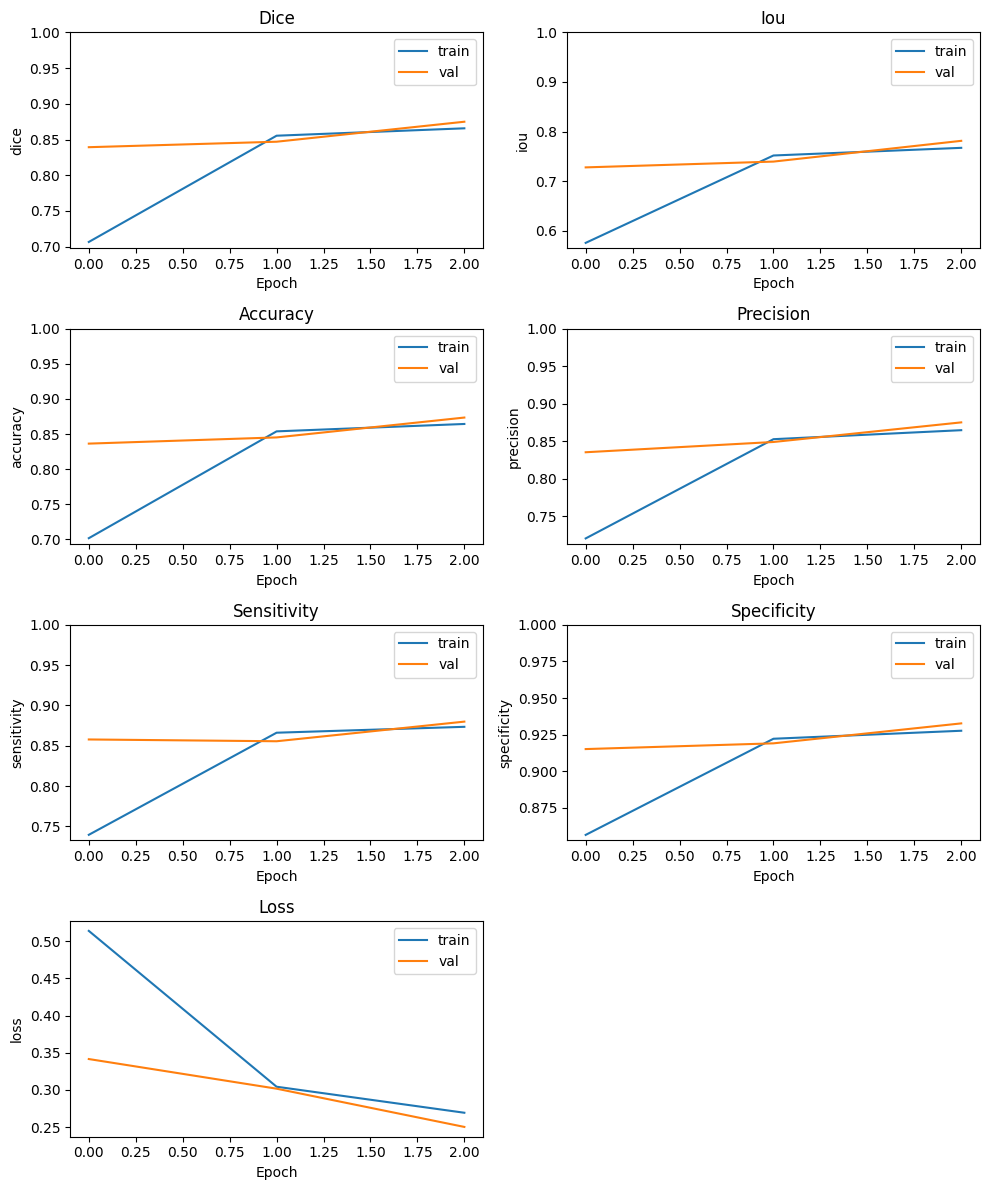

In [12]:
# Plot metrics
fig, ax = plt.subplots(4, 2, figsize=(10, 12))
ax = ax.ravel()
for i, metric in enumerate(['dice', 'iou', 'accuracy', 'precision', 'sensitivity', 'specificity', 'loss']):
    ax[i].plot(hist[f'train_{metric}'], label=f'train')
    ax[i].plot(hist[f'val_{metric}'], label=f'val')
    ax[i].set_title(metric[0].upper() + metric[1:])
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel(metric)
    if metric != 'loss':
        ax[i].set_ylim(top=1)
    ax[i].legend()
ax[-1].axis('off')
plt.tight_layout()
plt.show()

## Testing

In [13]:
def evaluate(model, criterion, device, loader):
    model.eval()
    model = model.to(device=device)
    history = defaultdict(list)
    total = len(loader)
    loop = tqdm(loader, total=total, leave=True, desc='Evaluating')
    mean_metrics = None

    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(loop):
            images = images.to(device=device)
            masks = masks.to(device=device)

            # forward pass
            outputs = model(images)
            loss = criterion(outputs, masks.long())

            # performance metrics
            preds = torch.argmax(outputs, dim=1)
            metrics = get_performance_metrics(masks.cpu(), preds.cpu())

            # update history
            history['loss'].append(loss.item())
            for k, v in metrics.items():
                history[k].append(v)

            # show mean metrics after every batch
            mean_metrics = {k: np.mean(v) for k, v in history.items()}
            loop.set_postfix(**mean_metrics)

    return mean_metrics

In [14]:
results = evaluate(model, criterion, DEVICE, test_loader)

Evaluating:   4%|▍         | 1/25 [00:04<01:47,  4.49s/it, accuracy=0.859, dice=0.864, iou=0.763, loss=0.265, precision=0.875, sensitivity=0.858, specificity=0.928]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7574, 0.4502, 0.6253],
        [0.9100, 0.8385, 0.8314],
        [0.8433, 0.6967, 0.7257],
        [0.7293, 0.7441, 0.7711]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.6110, 0.8600, 0.7552, 0.7481], device='cuda:0')
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7436, device='cuda:0')
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7816, 0.7301, 0.7597],
        [0.8558, 0.7594, 0.6624],
        [0.8416, 0.6056, 0.5994],
        [0.5196, 0.4015, 0.4916]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores 

Evaluating:  20%|██        | 5/25 [00:04<00:12,  1.61it/s, accuracy=0.866, dice=0.869, iou=0.773, loss=0.256, precision=0.878, sensitivity=0.866, specificity=0.931]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8030, 0.7560, 0.7578],
        [0.8623, 0.8324, 0.7994],
        [0.8724, 0.8035, 0.8447],
        [0.9020, 0.8233, 0.7153]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7723, 0.8314, 0.8402, 0.8135], device='cuda:0')
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.8143, device='cuda:0')
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8779, 0.6960, 0.6670],
        [0.9066, 0.7232, 0.4979],
        [0.8599, 0.8041, 0.8045],
        [0.7982, 0.7364, 0.6144]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores 

Evaluating:  36%|███▌      | 9/25 [00:05<00:04,  3.81it/s, accuracy=0.855, dice=0.858, iou=0.755, loss=0.272, precision=0.86, sensitivity=0.864, specificity=0.924] 

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7649, 0.7420, 0.7134],
        [0.8501, 0.8000, 0.7514],
        [0.8885, 0.7274, 0.5229],
        [0.8511, 0.8436, 0.8213]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7401, 0.8005, 0.7129, 0.8387], device='cuda:0')
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7730, device='cuda:0')
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7872, 0.6988, 0.7461],
        [0.7595, 0.6826, 0.6669],
        [0.8180, 0.7553, 0.6901],
        [0.6945, 0.6069, 0.3391]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores 

Evaluating:  52%|█████▏    | 13/25 [00:05<00:01,  6.74it/s, accuracy=0.861, dice=0.863, iou=0.763, loss=0.266, precision=0.864, sensitivity=0.869, specificity=0.926]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8492, 0.8511, 0.8493],
        [0.8764, 0.7419, 0.7424],
        [0.8913, 0.6342, 0.2117],
        [0.8755, 0.8121, 0.7257]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.8498, 0.7869, 0.5790, 0.8044], device='cuda:0')
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.7551, device='cuda:0')
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8277, 0.8286, 0.8499],
        [0.8725, 0.8366, 0.8139],
        [0.8789, 0.8069, 0.7843],
        [0.8204, 0.7097, 0.6032]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores 

Evaluating:  68%|██████▊   | 17/25 [00:05<00:00,  9.86it/s, accuracy=0.858, dice=0.86, iou=0.759, loss=0.269, precision=0.863, sensitivity=0.866, specificity=0.925] 

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.9168, 0.7761, 0.5974],
        [0.7248, 0.7371, 0.8042],
        [0.4025, 0.0827, 0.4118],
        [0.8338, 0.6909, 0.7717]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7634, 0.7554, 0.2990, 0.7655], device='cuda:0')
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.6458, device='cuda:0')
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8510, 0.7250, 0.6806],
        [0.8077, 0.7152, 0.5696],
        [0.8720, 0.7830, 0.7297],
        [0.8738, 0.8375, 0.7363]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores 

Evaluating:  76%|███████▌  | 19/25 [00:05<00:00, 11.20it/s, accuracy=0.866, dice=0.868, iou=0.771, loss=0.258, precision=0.871, sensitivity=0.873, specificity=0.929]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.7736, 0.7840, 0.7815],
        [0.8954, 0.8506, 0.8305],
        [0.8847, 0.7937, 0.7710],
        [0.9004, 0.8219, 0.7407]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.7797, 0.8588, 0.8165, 0.8210], device='cuda:0')
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.8190, device='cuda:0')
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8862, 0.8326, 0.7315],
        [0.8913, 0.7708, 0.7382],
        [0.8554, 0.7860, 0.8023],
        [0.8529, 0.8231, 0.8262]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores 

Evaluating:  92%|█████████▏| 23/25 [00:05<00:00, 13.47it/s, accuracy=0.868, dice=0.871, iou=0.775, loss=0.255, precision=0.873, sensitivity=0.874, specificity=0.931]

targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8523, 0.8005, 0.7600],
        [0.9087, 0.7607, 0.7216],
        [0.8061, 0.7628, 0.8121],
        [0.8349, 0.8288, 0.8147]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores = tensor([0.8043, 0.7970, 0.7937, 0.8261], device='cuda:0')
iou_scores.shape = torch.Size([]), iou_scores = tensor(0.8053, device='cuda:0')
targets_one_hot.shape = torch.Size([4, 3, 128, 128])
probabilities.shape = torch.Size([4, 3, 128, 128])
intersection.shape = torch.Size([4, 3])
union.shape = torch.Size([4, 3])
iou_scores.shape = torch.Size([4, 3]), iou_scores = tensor([[0.8415, 0.4974, 0.6166],
        [0.8892, 0.7211, 0.6829],
        [0.8522, 0.8144, 0.7968],
        [0.6841, 0.4923, 0.4621]], device='cuda:0')
iou_scores.shape = torch.Size([4]), iou_scores 

Evaluating: 100%|██████████| 25/25 [00:06<00:00,  3.70it/s, accuracy=0.866, dice=0.868, iou=0.771, loss=0.258, precision=0.871, sensitivity=0.872, specificity=0.929]


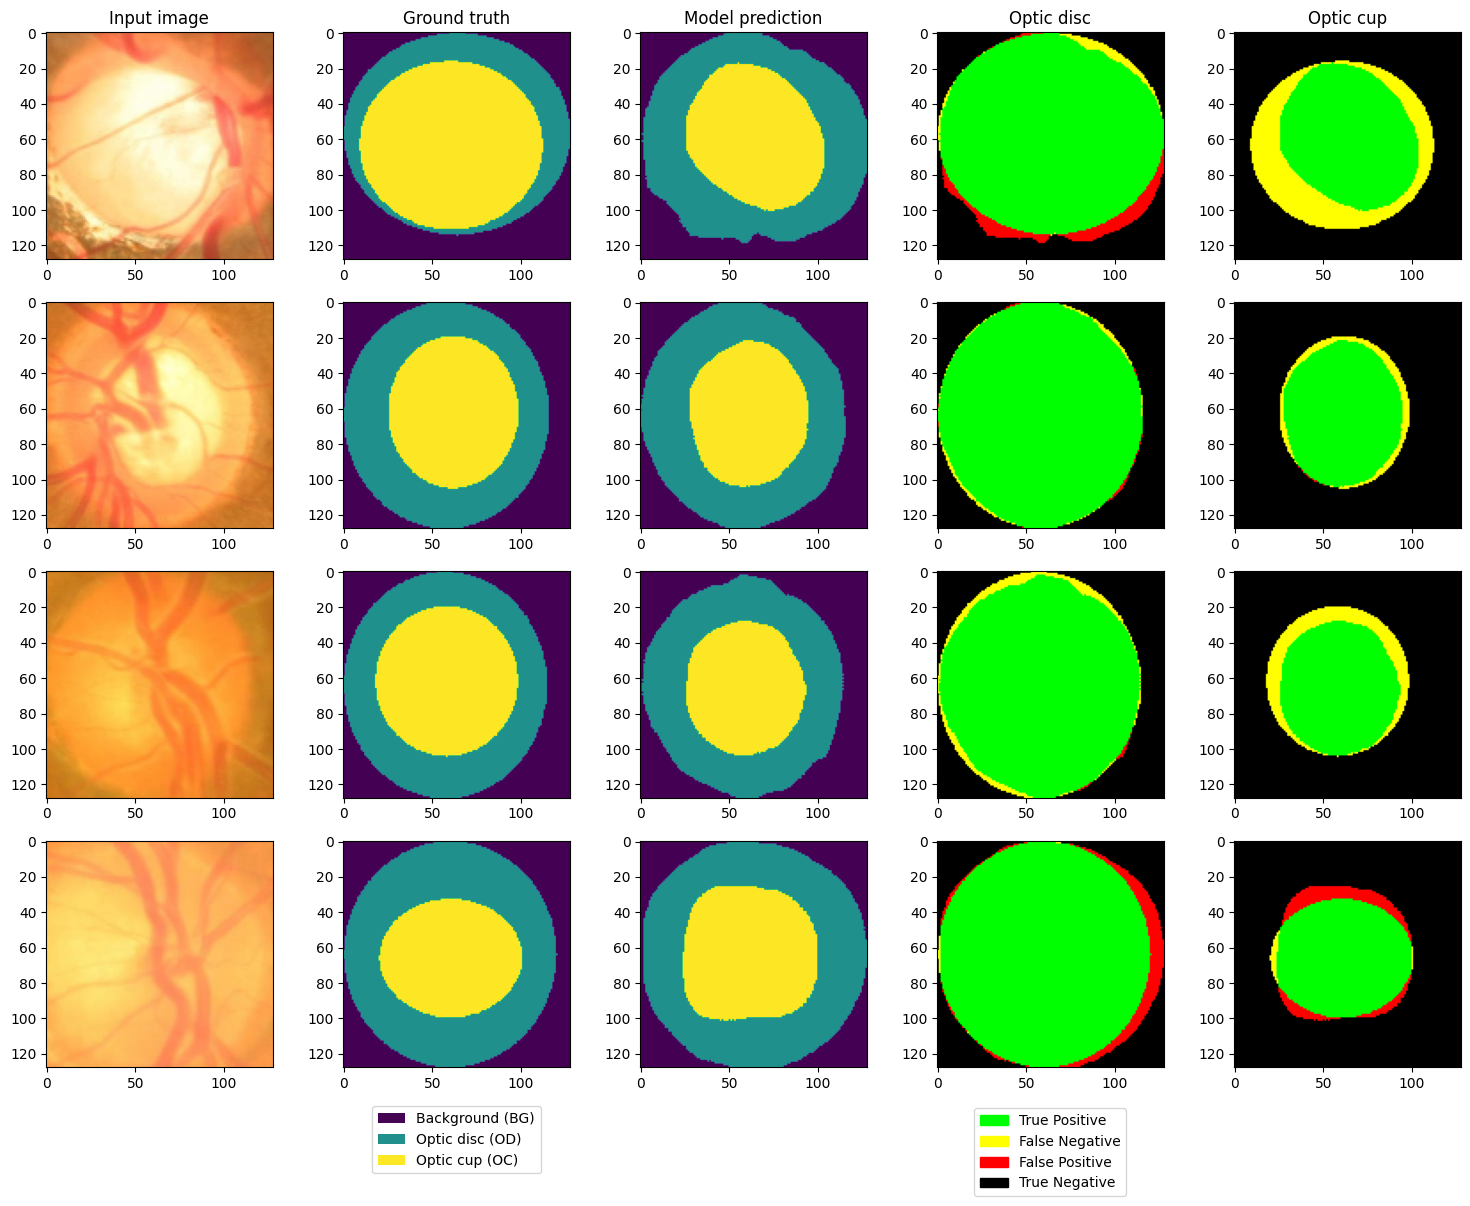

In [15]:
plot_results_from_loader(test_loader, model, DEVICE, f'{LOGS_DIR}/eval.png', mean=ORIGA_MEANS, std=ORIGA_STDS)

In [16]:
if USE_WANDB:
    wandb.finish()